In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Show all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr" # change to all, to show all


# Set Up Reading Waste Tables

In [2]:
datasets = {
            "waste_generation": {
                "table": "env_wasgen",
                "description": "Generation of waste by waste category, hazardousness and NACE Rev. 2 activity",
                "last_update": "30/05/2023 23:00"
            },
            "waste_treatment": {
                "table": "env_wastrt",
                "description": "Treatment of waste by waste category, hazardousness and waste management operations",
                "last_update": "30/05/2023 23:00"
            },
            "waste_management_operations": {
                "table": "env_wasoper",
                "description": "Management of waste excluding major mineral waste, by waste management operations",
                "last_update": "19/01/2023 11:00"
            },
            "waste_flow_management": {
                "table": "env_wasflow",
                "description": "Management of waste excluding major mineral waste, by waste management operations and waste flow",
                "last_update": "19/01/2023 11:00"
            },
            "recovery_disposal_facilities": {
                "table": "env_wasfac",
                "description": "Number and capacity of recovery and disposal facilities by NUTS 2 regions",
                "last_update": "14/09/2022 23:00"
            },
            "waste_management_sankey_diagram": {
                "table": "env_wassd",
                "description": "Management of waste by waste management operations and type of material - Sankey diagram data",
                "last_update": "20/02/2023 11:00"
            },
            "food_waste": {
                "table": "env_wasfw",
                "description": "Food waste and food waste prevention by NACE Rev. 2 activity - tonnes of fresh mass",
                "last_update": "06/03/2023 23:00"
            },
            "waste_trade": {
                "table": "env_wastrdmp",
                "description": "Trade in waste by type of material and partner",
                "last_update": "24/05/2022 23:00"
            },
            "packaging_waste": {
                "table": "env_waspac",
                "description": "Packaging waste by waste management operations",
                "last_update": "21/03/2023 23:00"
            },
            "packaging_waste_recycling": {
                "table": "env_waspacr",
                "description": "Recycling rates of packaging waste for monitoring compliance with policy targets, by type of packaging",
                "last_update": "21/03/2023 23:00"
            },
            "plastic_bag_consumption": {
                "table": "env_waspcb",
                "description": "Consumption of lightweight plastic carrier bags by their wall thickness",
                "last_update": "15/11/2022 23:00"
            },
            "electronic_waste_open_scope": {
                "table": "env_waseleeos",
                "description": "Waste electrical and electronic equipment (WEEE) by waste management operations - open scope, 6 product categories (from 2018 onwards)",
                "last_update": "17/03/2023 23:00"
            },
            "electronic_waste": {
                "table": "env_waselee",
                "description": "Waste electrical and electronic equipment (WEEE) by waste management operations",
                "last_update": "01/03/2022 11:00"
            },
            "portable_battery_collection": {
                "table": "env_waspb",
                "description": "Sales and collection of portable batteries and accumulators",
                "last_update": "02/02/2023 23:00"
            },
            "battery_recycling": {
                "table": "env_wasbat",
                "description": "Recycling of batteries and accumulators",
                "last_update": "02/02/2023 23:00"
            },
            "end_of_life_vehicles_detailed": {
                "table": "env_waselv",
                "description": "End-of-life vehicles by waste management operations - detailed data",
                "last_update": "06/07/2023 23:00"
            },
            "end_of_life_vehicles_totals": {
                "table": "env_waselvt",
                "description": "End-of-life vehicles - reuse, recycling and recovery, totals",
                "last_update": "06/07/2023 23:00"
            },
            "transboundary_shipments": {
                "table": "env_wasship",
                "description": "Transboundary shipments of notified waste by partner, hazardousness and waste management operations",
                "last_update": "04/11/2022 23:00"
            },
            "municipal_waste": {
                "table": "env_wasmun",
                "description": "Municipal waste by waste management operations",
                "last_update": "14/04/2023 23:00"
            }
        }

In [3]:
len(datasets)

19

In [14]:
def get_data(dataset):
    df = pd.read_pickle(f"../Datasets/{datasets[dataset]['table']}.pickle")

    for col in df.columns:
        if len(df[col].unique()) < 2:
            print(f'Deleted {col}, with value {df.loc[0, col]}')
            df = df.drop(col, axis = 1)
            
    return df


In [16]:
def csv_to_pickle():
    for dataset in datasets:
        df = pd.read_csv(f"../Data/{datasets[dataset]['table']}_linear.csv")
        df.to_pickle(f"../Datasets/{datasets[dataset]['table']}_linear.pickle")

## Wastes & Activities

In [17]:
aggregated_wastes = {
    'PRIM' : 'primary waste = total - sec',
    'SEC' : 'secondary waste = W033 + W103 + W128_13 (from waste treatment)',
    'TOTAL' : 'total waste' ,
    'TOT_X_MIN' : 'waste excluding major mineral wastes (lacks identification of major mineral wastes)',
    'W01-05' : 'total of: chemical compound wastes, chemical preparation wastes, other chemical wastes, health care and biological wastes (industrial or not)',
    'W06' : 'Metallic wastes = W061+W062+W063 ',
    'W06_07A' : 'Recycable wastes = W06 + W07 - W077',
    'W077_08' : 'Equipment = W077+W08A+W081+W0841',
    'W09' : 'Animal and vegetal wastes = W091+W092+W093',
    'W091_092' : 'Animal and mixed food waste; vegetal wastes = W091+W092',
    'W10' : 'Mixed ordinary wastes = W101+W102+W103',
    'W12-13' : 'Mineral and solidified wastes = W12 + W13',
    'W126_127' : 'Soils and dredging spoils = W126+W127 (valid up to 2008)'
}

non_aggregated_wastes = {
    'W011' : 'Spent solvents',
    'W012' : 'Acid, alkaline or saline wastes ',
    'W013' : 'Used oils (motor and non-motor)',
    'W02A' : 'Chemical wastes',
    'W032' : 'Industrial effluent sludges',
    'W033' : 'Sludges and liquid wastes from waste treatment',
    'W05'  : 'Health care and biological wastes',
    'W061' : 'Metallic wastes, ferrous',
    'W062' : 'Metallic wastes, non-ferrous ',
    'W063' : 'Metallic wastes, mixed ferrous and non-ferrous',
    'W071' : 'Glass wastes',
    'W072' : 'Paper and cardboard wastes',
    'W073' : 'Rubber wastes',
    'W074' : 'Plastic wastes',
    'W075' : 'Wood wastes',
    'W076' : 'Textile wastes',
    'W077' : 'Waste containing PCB',
    'W081' : 'Discarded vehicles',
    'W0841': 'Batteries and accumulators wastes',
    'W08A' : 'Discarded equipment = W08 - (W081 + W0841)',
    'W091' : 'Animal and mixed food waste',
    'W092' : 'Vegetal wastes',
    'W093' : 'Animal faeces, urine and manure',
    'W101' : 'Household and similar wastes',
    'W102' : 'Mixed and undifferentiated materials',
    'W103' : 'Sorting residues',
    'W11'  : 'Common sludges',
    'W121' : 'Mineral waste from construction and demolition',
    'W124' : 'Combustion wastes',
    'W126' : 'Soils',
    'W127' : 'Dredging spoils',
    'W128_13' : 'Mineral wastes from waste treat and stabilised wastes',
    'W12A' : 'Mineral wastes = W121+122+W123+W125+W126',
    'W12B' : 'Other mineral wastes = W122+W123+W125',
    'W12_X_127NH' : 'Mineral waste (except non-hazardous dredging spoils)',
    'W13' : 'Solidified, stabilised or vitrified wastes'
}

nace_r2 = {
'A' : 'Agriculture, forestry and fishing',
'B' : 'Mining and quarrying',
'C' : 'Manufacturing',
'C10-C12' : 'Man. food products; beverages and tobacco',
'C13-C15' : 'Man. textiles, wearing apparel, leather, ...',
'C16' : 'Man. wood and products of wood and cork',
'C17_C18' :  'Man. paper and paper products; printing of recorded media',
'C19' : 'Man. coke and refined petroleum products',
'C20-C22': 'Man. chemical, pharmaceutical, rubber and plastic products',
'C23' : 'Man. other non-metallic mineral products',
'C24_C25' : 'Man. basic metals and fabricated metal products',
'C26-C30' : 'Man.eltronics, motor vehicles and other transport eq.',
'C31-C33' : 'Man.furniture; jewellery, musical instruments, toys',
'D' : 'Electricity, gas, steam and air conditioning supply',
'E' : 'Water supply; sewerage, waste management and remediation activities',
'E36_E37_E39' : 'Water collection, treatment and supply; sewerage',
'E38' : 'Waste collection, treatment and disposal; materials recovery',
'EP_HH' : 'Households',
'F' : 'Construction',
'G-U_X_G4677' : 'Services (except wase wholesale, scrap)',
'G4677' : 'Wholesale of waste and scrap',
'TOTAL_HH' : 'All NACE activities plus households'
}

# Extracting European Geodata

Database extracted form [GISCO](https://gisco-services.ec.europa.eu/distribution/v2/nuts/nuts-2021-files.html), which contains the NUTS (statistical) regions of Europe.
Most recent data is from 2021

In [18]:
def get_countries():
    # read geodata europe
    countries = gpd.read_file("../Datasets/NUTS_RG_20M_2021_3035/NUTS_RG_20M_2021_3035.shp") 
    # level 0 indicates contries
    countries = countries[countries['LEVL_CODE'] == 0]
    return countries

def plot_countries(countries):
    ax = countries.plot()
    # cut out islands form the plot
    ax.set_xlim(2000000, 8000000)
    ax.set_ylim(1000000, 5500000)

In [19]:
countries = get_countries()
countries.head()

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,FR,0,FR,France,France,0.0,0,0,FR,"MULTIPOLYGON (((9954236.116 -3059379.316, 9961..."
1,HR,0,HR,Hrvatska,Hrvatska,0.0,0,0,HR,"MULTIPOLYGON (((4827385.889 2618351.326, 48483..."
2,HU,0,HU,Magyarország,Magyarország,0.0,0,0,HU,"POLYGON ((5214660.069 2880853.832, 5216710.220..."
3,AL,0,AL,Shqipëria,Shqipëria,0.0,0,0,AL,"POLYGON ((5129579.170 2204098.752, 5148385.473..."
4,AT,0,AT,Österreich,Österreich,0.0,0,0,AT,"POLYGON ((4742889.368 2876362.725, 4783217.798..."


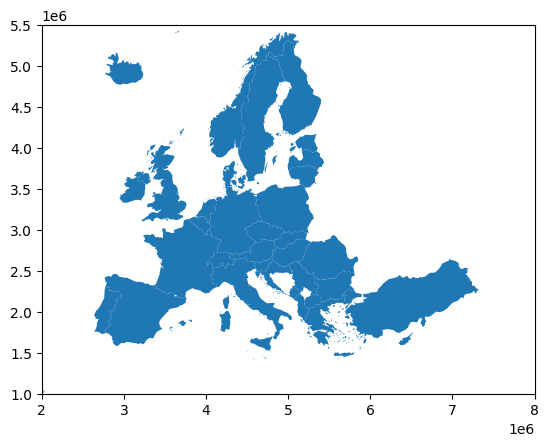

In [20]:
plot_countries(countries)

In [21]:
def get_geometry(data, countries):
    gdf = gpd.GeoDataFrame(data.merge(countries[['NUTS_ID', 'geometry']].rename(columns={'NUTS_ID':'geo'}), 
                                          on='geo', how='left'))
    return gdf

# Extracting Waste Generation Data

In [22]:
wasgen = get_data('waste_generation')
wasgen.head()

Deleted DATAFLOW, with value ESTAT:ENV_WASGEN(1.0)
Deleted LAST UPDATE, with value 13/01/23 23:00:00
Deleted freq, with value A


,unit,hazard,nace_r2,waste,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,KG_HAB,HAZ,A,PRIM,AT,2010,9.0,NaN
1,KG_HAB,HAZ,A,PRIM,AT,2012,1.0,NaN
2,KG_HAB,HAZ,A,PRIM,AT,2014,1.0,NaN
3,KG_HAB,HAZ,A,PRIM,AT,2016,NaN,c
4,KG_HAB,HAZ,A,PRIM,AT,2018,1.0,NaN


In [23]:
wasgen_percapita = wasgen[wasgen.unit == "KG_HAB"].drop('unit', axis = 1)
wasgen_total = wasgen[wasgen.unit == "T"].drop('unit', axis = 1)
wasgen_total = get_geometry(wasgen_total, countries)

In [24]:
wasgen_total.geo.unique()

array(['AT', 'BA', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES',
       'EU27_2020', 'EU28', 'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT',
       'LI', 'LT', 'LU', 'LV', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT',
       'RO', 'RS', 'SE', 'SI', 'SK', 'TR', 'UK', 'XK', 'AL'], dtype=object)

### Most Relevant Waste Categories

In [25]:
# group by geo and then calculate the weight of each waste on Total Waste per year per country

df = wasgen_total.groupby(['geo', 'waste', 'TIME_PERIOD'], as_index=False).agg({'OBS_VALUE':'sum', 'geometry':'first'})

df = df.merge(df.loc[df.waste == 'TOTAL', 
                 ['geo', 'TIME_PERIOD', 'OBS_VALUE']] \
                .rename(columns={'OBS_VALUE': 'TOTAL'}),
             on= ['geo', 'TIME_PERIOD'],
             how = 'left')

df['VALUE_PERC'] = round(df.OBS_VALUE / df.TOTAL * 100, 2)

df[df.TIME_PERIOD == 2020].geo.unique()

array(['AT', 'BA', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES',
       'EU27_2020', 'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU',
       'LV', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE',
       'SI', 'SK', 'TR', 'UK', 'XK'], dtype=object)

In [26]:
df.head()

,geo,waste,TIME_PERIOD,OBS_VALUE,geometry,TOTAL,VALUE_PERC
0,AL,PRIM,2014,4915536.0,"POLYGON ((5129579.170 2204098.752, 5148385.473...",NaN,NaN
1,AL,W011,2010,0.0,"POLYGON ((5129579.170 2204098.752, 5148385.473...",NaN,NaN
2,AL,W011,2012,0.0,"POLYGON ((5129579.170 2204098.752, 5148385.473...",NaN,NaN
3,AL,W011,2014,0.0,"POLYGON ((5129579.170 2204098.752, 5148385.473...",NaN,NaN
4,AL,W011,2016,0.0,"POLYGON ((5129579.170 2204098.752, 5148385.473...",NaN,NaN


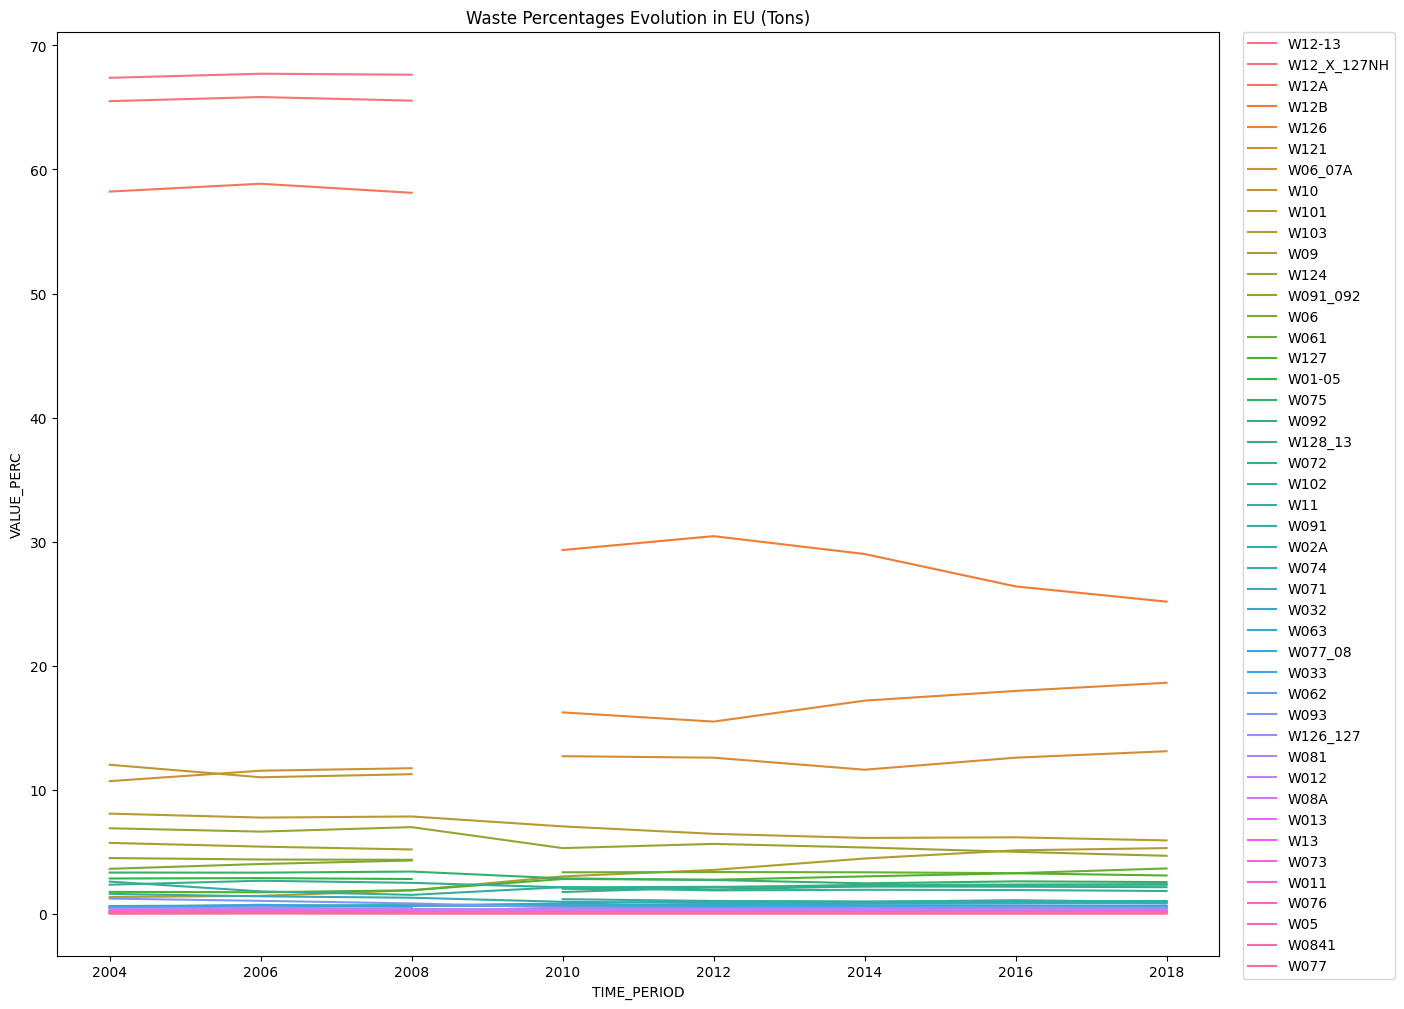

In [27]:
fig, ax =plt.subplots(figsize=(15,12))

df = df[~df.waste.isin(['TOTAL','PRIM','SEC','TOT_X_MIN']) & (df.geo == 'EU28')]

plt.title("Waste Percentages Evolution in EU (Tons)")

# order countries by last value
sorted_wastes = df.sort_values(['TIME_PERIOD'], ascending=False).drop_duplicates('waste', keep='first') \
                     .sort_values('VALUE_PERC', ascending=False).waste

sns.lineplot(df, x='TIME_PERIOD', y='VALUE_PERC', hue = 'waste', hue_order=sorted_wastes, ax=ax)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


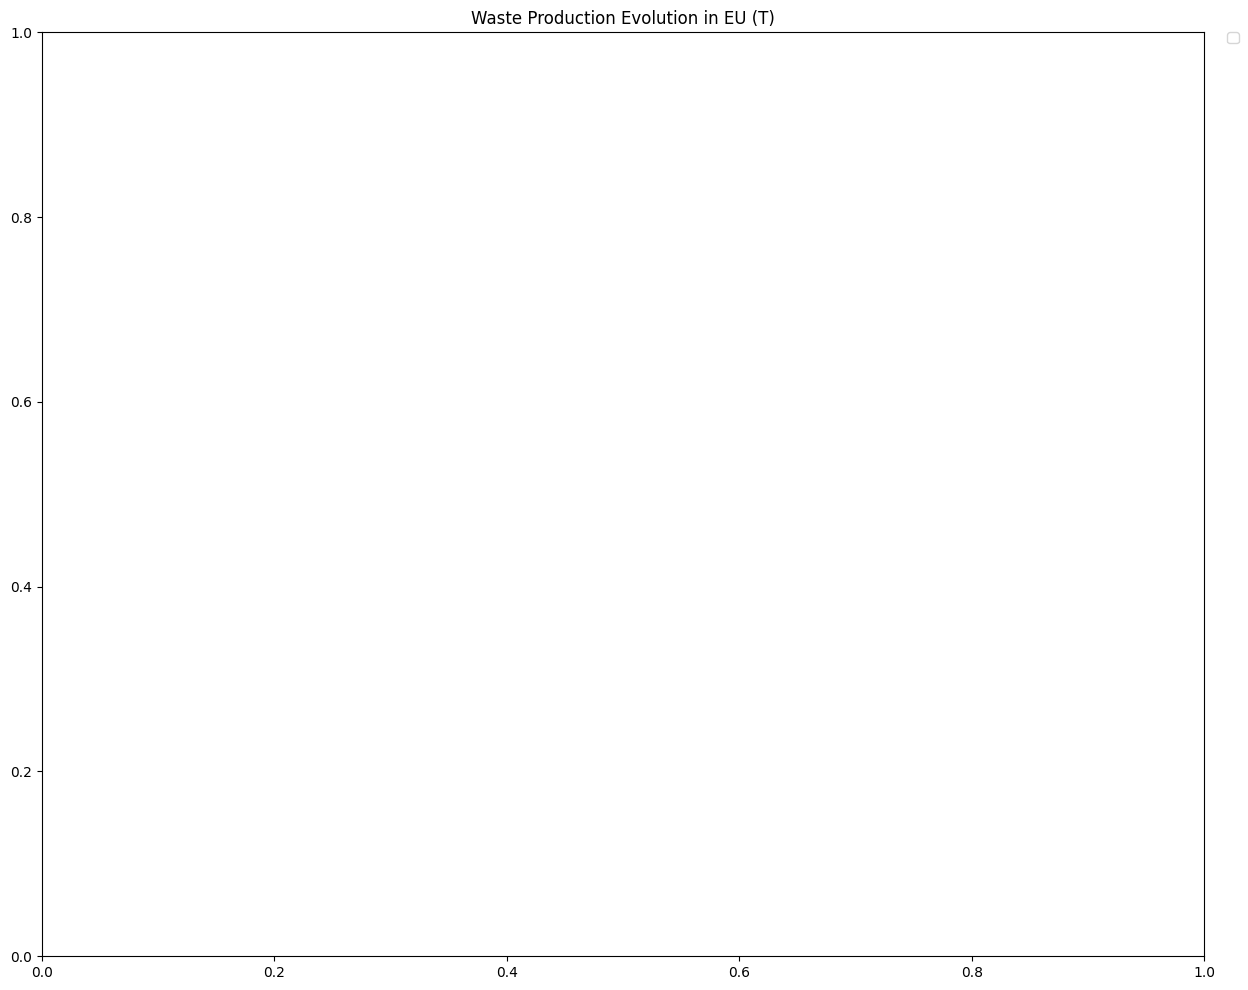

In [28]:
noise_wastes = ['W12-13', 'W12_X_127NH', 'W12A', 'W12B', 'W126', 'W121', 'W06_07A', 'W10']
# only up to 2008 and outliers

fig, ax =plt.subplots(figsize=(15,12))

df = df[~df.waste.isin(['TOTAL','PRIM','SEC','TOT_X_MIN']) & (~df.geo.isin(['EU27_2020', 'EU28'])) & ~df.waste.isin(noise_wastes)]
data = df.groupby(['TIME_PERIOD', 'waste'], as_index=False).OBS_VALUE.sum()
plt.title("Waste Production Evolution in EU (T)")

# order countries by last value
sorted_wastes = data.sort_values(['TIME_PERIOD'], ascending=False).drop_duplicates('waste', keep='first') \
                     .sort_values('OBS_VALUE', ascending=False).waste

sns.lineplot(data, x='TIME_PERIOD', y='OBS_VALUE', hue = 'waste', hue_order=sorted_wastes, ax=ax)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


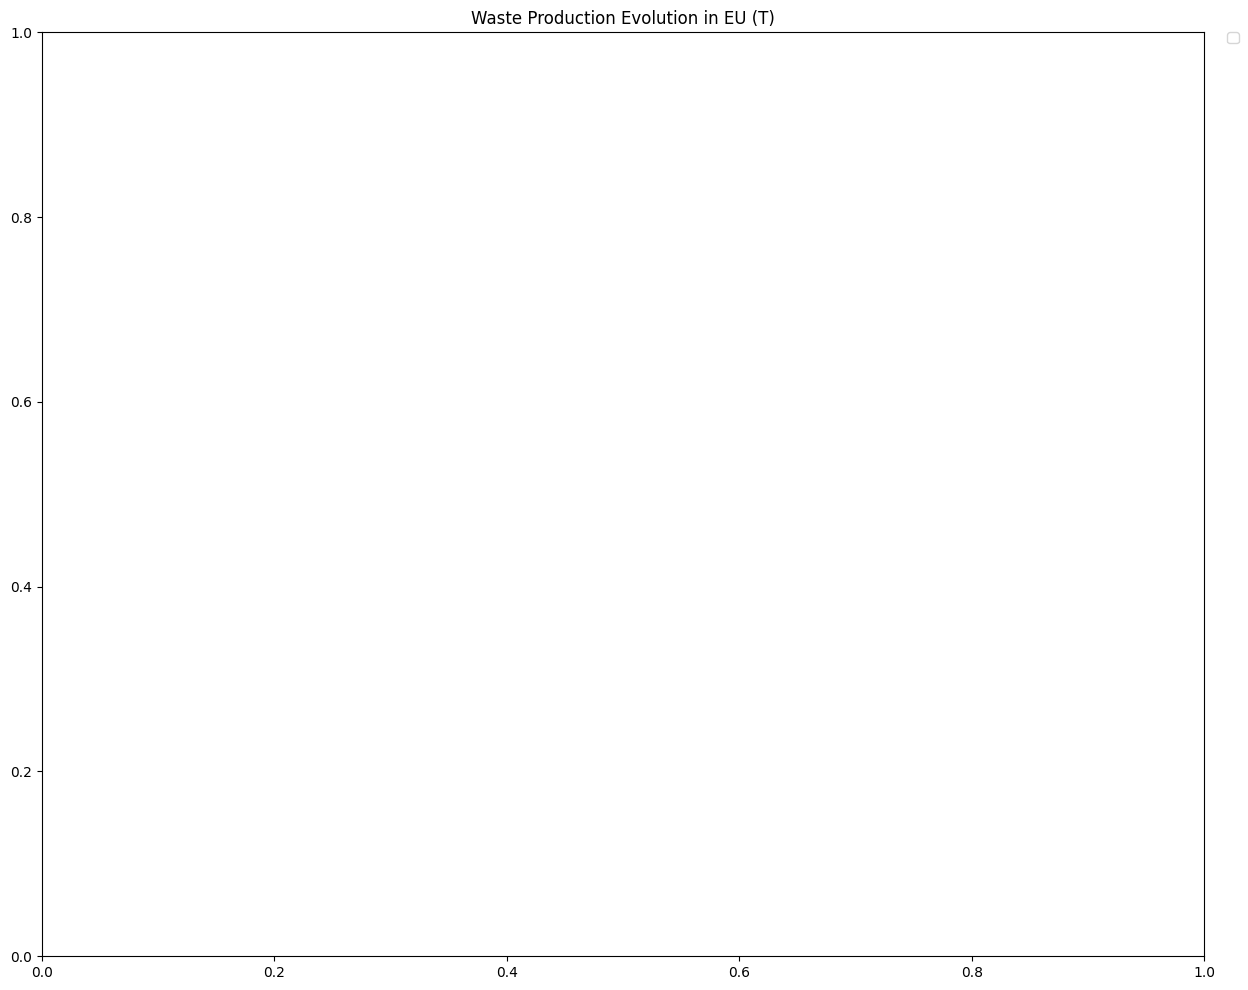

In [29]:
fig, ax =plt.subplots(figsize=(15,12))

data = df[df.waste.isin(['W075','W092']) & (~df.geo.isin(['EU27_2020', 'EU28'])) & ~df.waste.isin(noise_wastes)]
data = data.groupby(['TIME_PERIOD', 'waste'], as_index=False).OBS_VALUE.sum()
plt.title("Waste Production Evolution in EU (T)")

# order countries by last value
sorted_wastes = data.sort_values(['TIME_PERIOD'], ascending=False).drop_duplicates('waste', keep='first') \
                     .sort_values('OBS_VALUE', ascending=False).waste

sns.lineplot(data, x='TIME_PERIOD', y='OBS_VALUE', hue = 'waste', hue_order=sorted_wastes, ax=ax)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


plt.show()

In [30]:
df.TIME_PERIOD.max()

nan

# Industry & Waste Analysis

In [31]:
wasgen = get_data('waste_generation')
wasgen.head()

Deleted DATAFLOW, with value ESTAT:ENV_WASGEN(1.0)
Deleted LAST UPDATE, with value 13/01/23 23:00:00
Deleted freq, with value A


,unit,hazard,nace_r2,waste,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,KG_HAB,HAZ,A,PRIM,AT,2010,9.0,NaN
1,KG_HAB,HAZ,A,PRIM,AT,2012,1.0,NaN
2,KG_HAB,HAZ,A,PRIM,AT,2014,1.0,NaN
3,KG_HAB,HAZ,A,PRIM,AT,2016,NaN,c
4,KG_HAB,HAZ,A,PRIM,AT,2018,1.0,NaN


In [32]:
wasgen_geo = get_geometry(wasgen, countries)
wasgen_total = wasgen_geo[wasgen_geo.unit == 'T']

In [33]:
wasgen_total.head()

,unit,hazard,nace_r2,waste,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,geometry
735563,T,HAZ,A,PRIM,AT,2010,77314.0,NaN,"POLYGON ((4742889.368 2876362.725, 4783217.798..."
735564,T,HAZ,A,PRIM,AT,2012,9409.0,NaN,"POLYGON ((4742889.368 2876362.725, 4783217.798..."
735565,T,HAZ,A,PRIM,AT,2014,9331.0,NaN,"POLYGON ((4742889.368 2876362.725, 4783217.798..."
735566,T,HAZ,A,PRIM,AT,2016,NaN,c,"POLYGON ((4742889.368 2876362.725, 4783217.798..."
735567,T,HAZ,A,PRIM,AT,2018,9646.0,NaN,"POLYGON ((4742889.368 2876362.725, 4783217.798..."


### Which wastes do industries produce the most?

In [34]:
df = wasgen_total[(wasgen_total.geo == 'EU28') & wasgen_total.waste.isin(non_aggregated_wastes.keys())].groupby(['nace_r2', 'waste', 'TIME_PERIOD'],
                                                                                                                as_index = False).OBS_VALUE.sum()
df.head()


,nace_r2,waste,TIME_PERIOD,OBS_VALUE
0,A,W011,2004,20000.0
1,A,W011,2006,20000.0
2,A,W011,2008,0.0
3,A,W011,2010,0.0
4,A,W011,2012,0.0


In [35]:
df = df.groupby(['nace_r2', 'waste'], as_index = False).OBS_VALUE.sum()

df = df.sort_values(['nace_r2', 'OBS_VALUE'], ascending = [True, False])


In [36]:
df = df.groupby(['nace_r2']).head(5)
df['wastedisc'] = df['waste'].map(non_aggregated_wastes)
df['nace_r2_disc'] = df['nace_r2'].map(nace_r2)
df.head(10)

,nace_r2,waste,OBS_VALUE,wastedisc,nace_r2_disc
22,A,W093,2.632400e+08,"Animal faeces, urine and manure","Agriculture, forestry and fishing"
21,A,W092,3.870000e+07,Vegetal wastes,"Agriculture, forestry and fishing"
14,A,W075,2.415000e+07,Wood wastes,"Agriculture, forestry and fishing"
20,A,W091,9.600000e+06,Animal and mixed food waste,"Agriculture, forestry and fishing"
13,A,W074,8.920000e+06,Plastic wastes,"Agriculture, forestry and fishing"
69,B,W12B,6.607990e+09,Other mineral wastes = W122+W123+W125,Mining and quarrying
70,B,W12_X_127NH,3.814440e+09,Mineral waste (except non-hazardous dredging s...,Mining and quarrying
68,B,W12A,3.770900e+09,Mineral wastes = W121+122+W123+W125+W126,Mining and quarrying
64,B,W124,9.745000e+07,Combustion wastes,Mining and quarrying
65,B,W126,3.383000e+07,Soils,Mining and quarrying


In [37]:
len(df.nace_r2.unique())

22

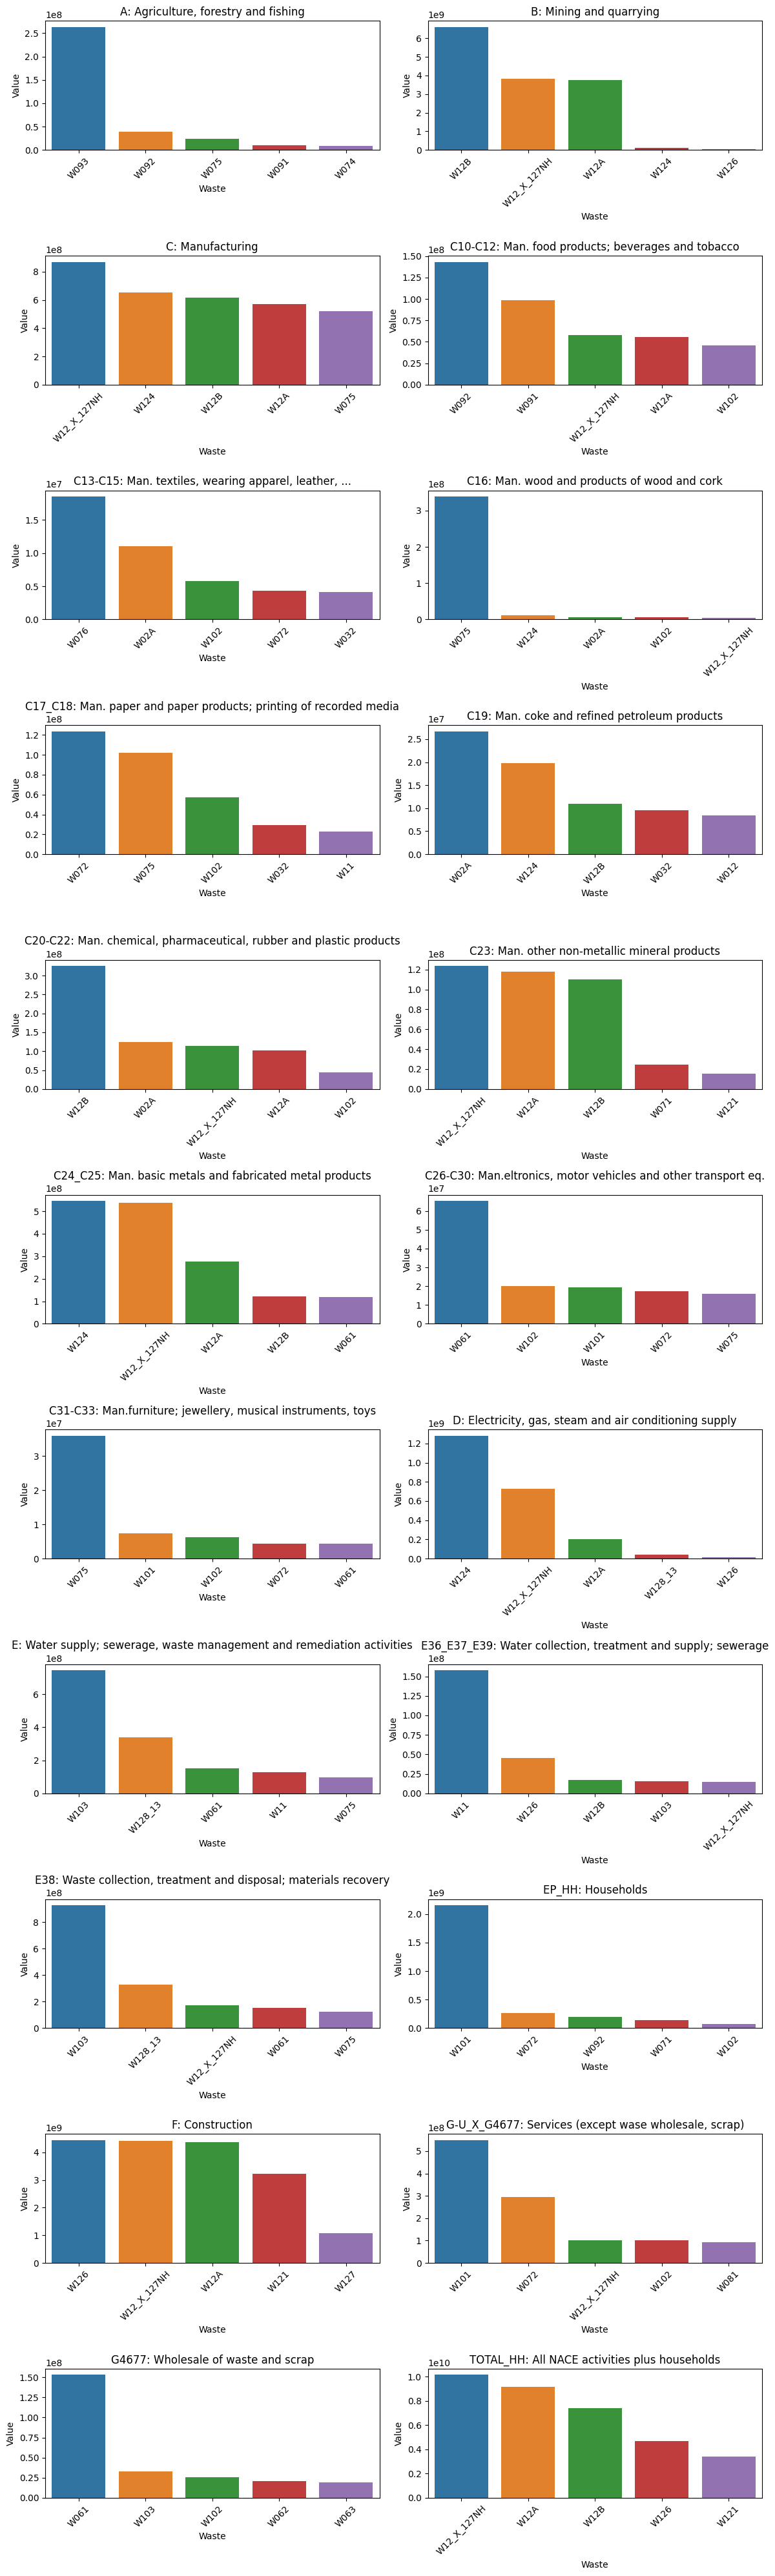

In [38]:
# Get the unique activities
activities = df['nace_r2'].unique()
wastes = df['waste'].unique()

# Calculate the number of subplots needed
num_subplots = len(activities)

# Set the number of rows and columns for subplots layout
num_rows = num_subplots // 2
num_cols = num_subplots // num_rows

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 40))

# Flatten the axes array if needed
if num_subplots > 1:
    axes = axes.flatten()

# Iterate over each activity and plot the corresponding bar plot
for i, activity in enumerate(activities):
    ax = axes[i] if num_subplots > 1 else axes  # Get the current subplot
    data = df[df['nace_r2'] == activity]  # Filter data for the current activity

    # Create the bar plot using seaborn
    sns.barplot(data=data, x='waste', y='OBS_VALUE', ax=ax)

    # Set the title and axes labels
    ax.set_title(f'{activity}: {nace_r2[activity]}')
    ax.set_xlabel('Waste')
    ax.set_ylabel('Value')

    # Rotate the x-axis labels if needed
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    # Add labels
    #ax.bar_label(ax.containers[0])


# Adjust the spacing between subplots

plt.tight_layout()

# Show the plot
plt.show()

## Which industries produce most of each waste

In [48]:
df = wasgen_total[(wasgen_total.geo == 'EU28') & \
                  wasgen_total.waste.isin(non_aggregated_wastes.keys()) & \
                 (~wasgen_total.nace_r2.isin(['TOTAL_HH','C',]))].groupby(['nace_r2', 'waste', 'TIME_PERIOD'],
                                                         as_index = False).OBS_VALUE.sum()

df = df.groupby(['nace_r2', 'waste'], as_index = False).OBS_VALUE.sum()

df = df.sort_values(['waste', 'OBS_VALUE'], ascending = [True, False])

df = df.groupby(['waste']).head(5)
df['wastedisc'] = df['waste'].map(non_aggregated_wastes)
df['nace_r2_disc'] = df['nace_r2'].map(nace_r2)
df.head(10)


,nace_r2,waste,OBS_VALUE,wastedisc,nace_r2_disc
252,C20-C22,W011,27980000.0,Spent solvents,"Man. chemical, pharmaceutical, rubber and plas..."
537,E38,W011,4640000.0,Spent solvents,"Waste collection, treatment and disposal; mate..."
468,E,W011,3520000.0,Spent solvents,"Water supply; sewerage, waste management and r..."
644,G-U_X_G4677,W011,3040000.0,Spent solvents,"Services (except wase wholesale, scrap)"
360,C26-C30,W011,1180000.0,Spent solvents,"Man.eltronics, motor vehicles and other transp..."
325,C24_C25,W012,37450000.0,"Acid, alkaline or saline wastes",Man. basic metals and fabricated metal products
253,C20-C22,W012,29300000.0,"Acid, alkaline or saline wastes","Man. chemical, pharmaceutical, rubber and plas..."
181,C17_C18,W012,9370000.0,"Acid, alkaline or saline wastes",Man. paper and paper products; printing of rec...
217,C19,W012,8470000.0,"Acid, alkaline or saline wastes",Man. coke and refined petroleum products
361,C26-C30,W012,5560000.0,"Acid, alkaline or saline wastes","Man.eltronics, motor vehicles and other transp..."


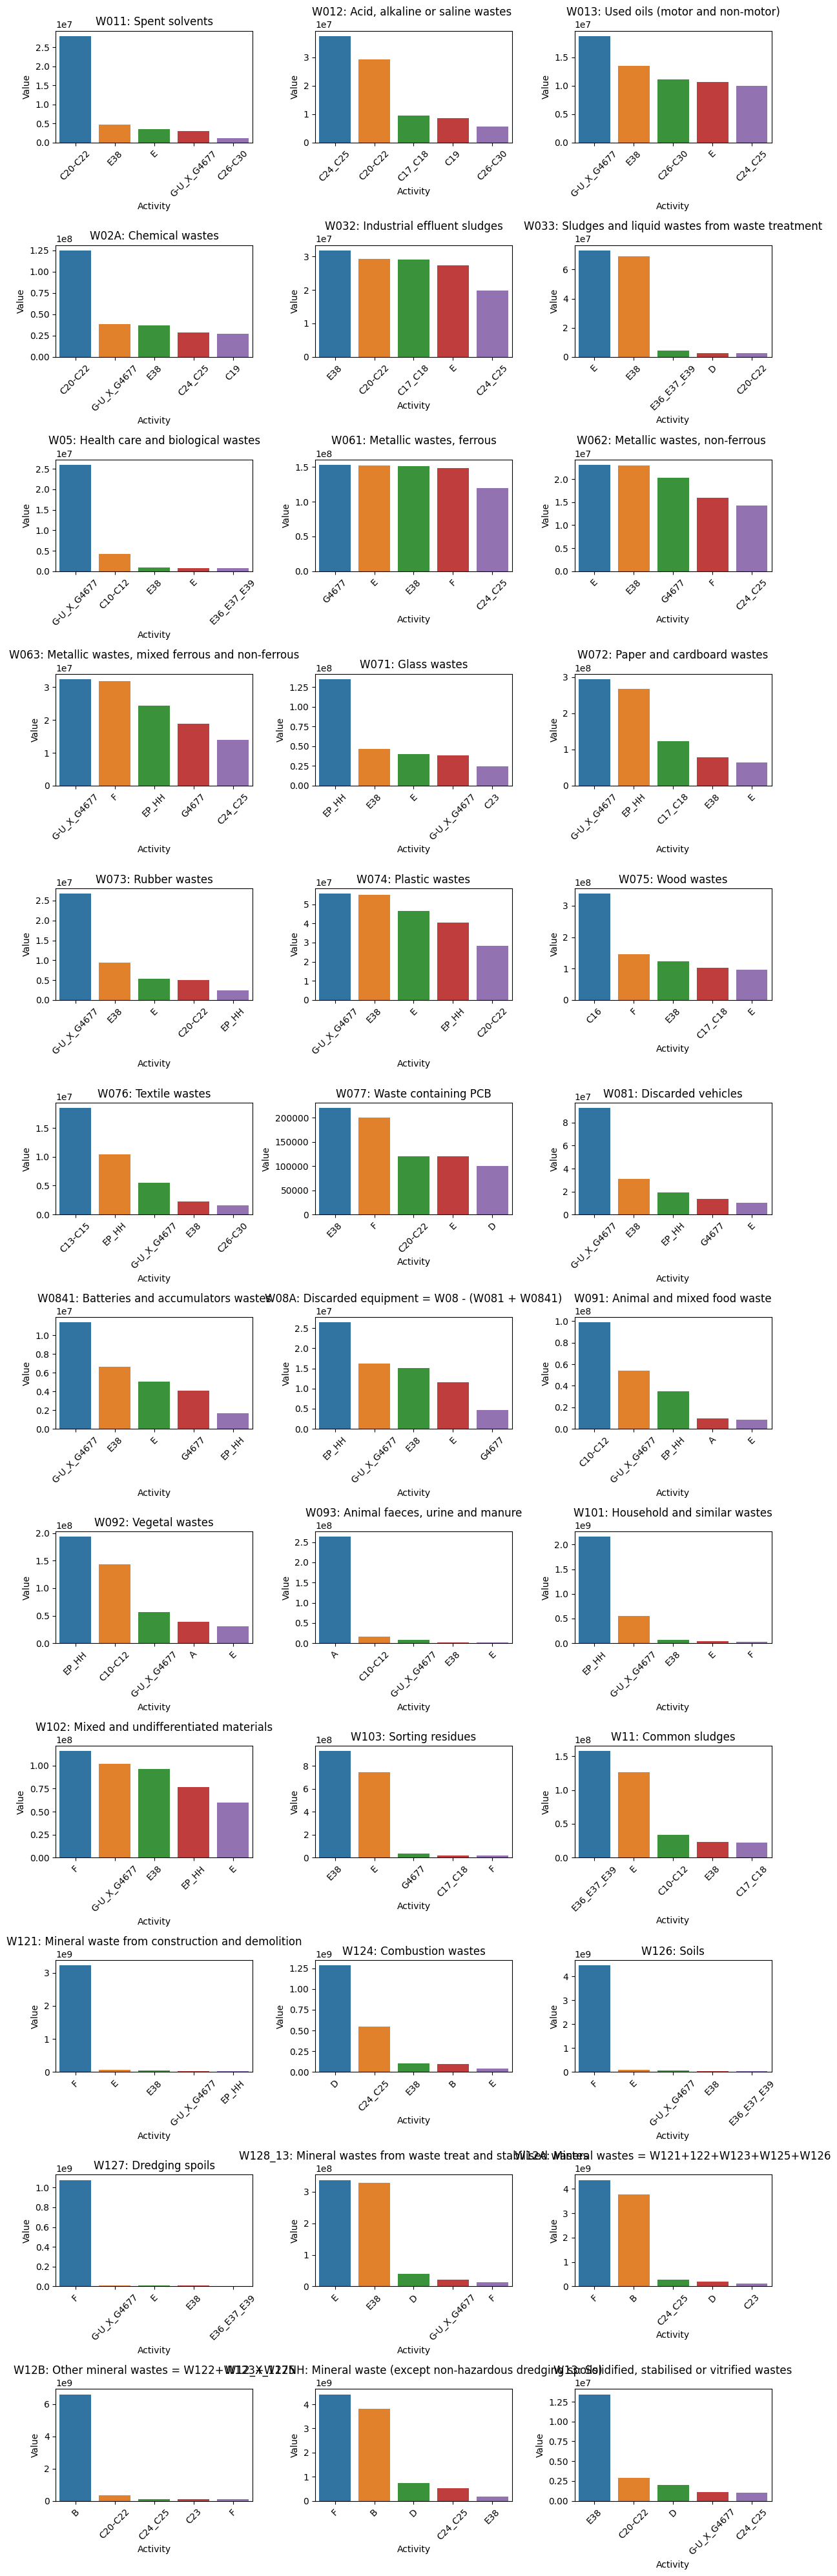

In [51]:
# Get the unique activities
activities = df['nace_r2'].unique()
wastes = df['waste'].unique()

# Calculate the number of subplots needed
num_subplots = len(wastes)

# Set the number of rows and columns for subplots layout
num_rows = num_subplots // 3
num_cols = num_subplots // num_rows

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 40))

# Flatten the axes array if needed
if num_subplots > 1:
    axes = axes.flatten()

# Iterate over each activity and plot the corresponding bar plot
for i, waste in enumerate(wastes):
    ax = axes[i] if num_subplots > 1 else axes  # Get the current subplot
    data = df[df['waste'] == waste]  # Filter data for the current activity

    # Create the bar plot using seaborn
    sns.barplot(data=data, x='nace_r2', y='OBS_VALUE', ax=ax)

    # Set the title and axes labels
    ax.set_title(f'{waste}: {non_aggregated_wastes[waste]}')
    ax.set_xlabel('Activity')
    ax.set_ylabel('Value')

    # Rotate the x-axis labels if needed
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    # Add labels
    #ax.bar_label(ax.containers[0])


# Adjust the spacing between subplots

plt.tight_layout()

# Show the plot
plt.show()

# Industry Analysis - Relevant Wastes and Industries

Considering [most relevant feedstocks and biorefinery pathways](https://docs.google.com/spreadsheets/d/1YXpfpVbIupB7pmP4PHMqfh8NO0MsXVcfd821D-wEXUc/edit#gid=657234966), and the available raw material data from waste production, and most producing economic activities, the following industries and wastes were chosen:

In [55]:
feedstock_nacer2 = {
'A' : 'Agriculture, forestry and fishing',
'C10-C12' : 'Man. food products; beverages and tobacco',
#'C16' : 'Man. wood and products of wood and cork',
#'C17_C18' :  'Man. paper and paper products; printing of recorded media',
#'C31-C33' : 'Man.furniture; jewellery, musical instruments, toys',
#'E38' : 'Waste collection, treatment and disposal; materials recovery',
#'G-U_X_G4677' : 'Services (except waste wholesale, scrap)',
#'E36_E37_E39' : 'Water collection, treatment and supply; sewerage',
#'EP_HH' : 'Households',
}

feedstocks = {
    #'W072' : 'Paper and cardboard wastes',
    #'W075' : 'Wood wastes',
    #'W091' : 'Animal and mixed food waste',
    'W092' : 'Vegetal wastes',
    'W093' : 'Animal faeces, urine and manure',
    #'W101' : 'Household and similar wastes',
    #'W102' : 'Mixed and undifferentiated materials', # Hard to find composition information
    #'W103' : 'Sorting residues',
    #'W11'  : 'Common sludges', # Sewage
}


## ⚠️ Limitation: Wastes are produced in other industries

Altough this wastes are produced in more industires they are either not substantial (top 3 industries for the waste) or there is lack of literatur on valorizing biomass form those industires (e.g. vehicle manufacturing.

The dataset will be reduced to include onluy these wastes.

In [56]:
biomass_wasgen = wasgen[wasgen.nace_r2.isin(feedstock_nacer2.keys()) & wasgen.waste.isin(feedstocks.keys())]
biomass_wasgen.head()

,unit,hazard,nace_r2,waste,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
7171,KG_HAB,HAZ,A,W092,AL,2010,NaN,z
7172,KG_HAB,HAZ,A,W092,AL,2012,NaN,z
7173,KG_HAB,HAZ,A,W092,AL,2014,NaN,z
7174,KG_HAB,HAZ,A,W092,AL,2016,NaN,z
7175,KG_HAB,HAZ,A,W092,AT,2010,NaN,z


In [57]:
biomass_wasgen.TIME_PERIOD.unique()

array([2010, 2012, 2014, 2016, 2018, 2020, 2004, 2006, 2008], dtype=int64)

# Geographic Analysis - since 2010 - Total Tons
or per capita?

In [58]:
def get_biomass_wasgen_geo(biomass_wasgen, unit, category = 'waste'):
    biomass_wasgen_total = biomass_wasgen[(biomass_wasgen.unit == unit) & (biomass_wasgen.geo != 'EU27_2020') & (biomass_wasgen.TIME_PERIOD >= 2010)].copy()
    
    if category == 'waste':
        biomass_wasgen_total = biomass_wasgen_total.groupby(['waste', 'geo'], as_index=False).OBS_VALUE.sum()
    else:
        biomass_wasgen_total = biomass_wasgen_total.groupby(['nace_r2', 'geo'], as_index=False).OBS_VALUE.sum()

    biomass_wasgen_geo = get_geometry(biomass_wasgen_total, countries)
    biomass_wasgen_geo = biomass_wasgen_geo[biomass_wasgen_geo.geometry != None]
    return biomass_wasgen_geo.copy()

biomass_wasgen_geo = get_biomass_wasgen_geo(biomass_wasgen, 'T', 'nace_r2')
biomass_wasgen_geo.head()

,nace_r2,geo,OBS_VALUE,geometry
0,A,AL,0.0,"POLYGON ((5129579.170 2204098.752, 5148385.473..."
1,A,AT,1285324.0,"POLYGON ((4742889.368 2876362.725, 4783217.798..."
3,A,BE,1124026.0,"POLYGON ((3957506.818 3167694.476, 3964175.126..."
4,A,BG,7820022.0,"POLYGON ((5363358.686 2390534.464, 5395245.631..."
5,A,CY,236720.0,"POLYGON ((6342668.882 1629618.498, 6342926.802..."


Vegetal wastes:  ['NL', 'BE', 'ES', 'FR', 'PL']
Animal faeces, urine and manure:  ['ES', 'NL', 'DE', 'SE', 'SK']


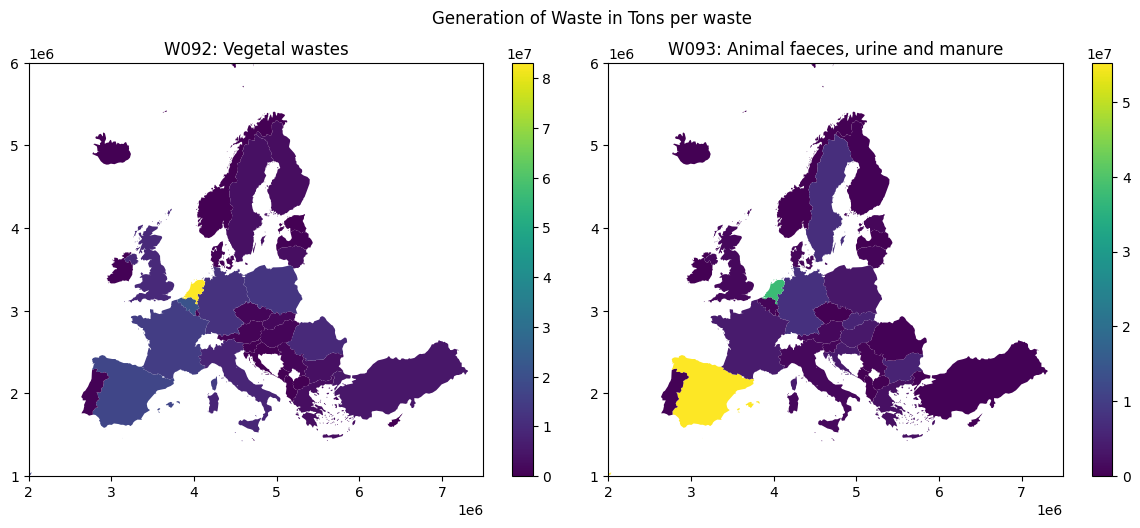

In [61]:
def plot_production_per_country(biomass_wasgen_geo, unit = 'T', category = 'waste'):

    df = get_biomass_wasgen_geo(biomass_wasgen, unit, category)

    # Get the unique activities
    categories = feedstocks.keys() if category == 'waste' else feedstock_nacer2.keys()

    # Calculate the number of subplots needed
    num_subplots = len(categories)

    # Set the number of rows and columns for subplots layout
    num_rows = num_subplots // 2
    num_cols = num_subplots // num_rows

    # Create the subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5))

    # Flatten the axes array if needed
    if num_subplots > 1:
        axes = axes.flatten()

    # Iterate over each activity and plot the corresponding bar plot
    for i, cat in enumerate(categories):
        ax = axes[i] if num_subplots > 1 else axes  # Get the current subplot

        # Create the map plot
        aux = df[df[category] == cat]
        aux.plot(column='OBS_VALUE', legend=True, ax=ax)
        ax.set_xlim(2000000, 7500000)
        ax.set_ylim(1000000, 6000000)

        aux = aux.sort_values('OBS_VALUE', ascending=False)
        # Set the title and axes labels
        if category == 'waste':
            ax.set_title(f'{cat}: {feedstocks[cat]}')
            # Print top 5 countreis
            print(f'{feedstocks[cat]}: ', list(aux.head().geo))
        else:
            ax.set_title(f'{cat}: {feedstock_nacer2[cat]}')
            # Print top 5 countreis
            print(f'{feedstock_nacer2[cat]}: ', list(aux.head().geo))


    fig.suptitle(f'Generation of Waste in Tons per {category}')
    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    
plot_production_per_country(biomass_wasgen, 'T', 'waste')

Paper and cardboard wastes:  ['BE', 'AT', 'LU', 'LI', 'UK']
Wood wastes:  ['FI', 'EE', 'BE', 'NO', 'RO']
Animal and mixed food waste:  ['IE', 'IS', 'LI', 'FI', 'NO']
Vegetal wastes:  ['NL', 'BE', 'DK', 'DE', 'AT']
Animal faeces, urine and manure:  ['NL', 'ES', 'SK', 'HR', 'BG']
Household and similar wastes:  ['MT', 'PT', 'CY', 'ES', 'IE']
Sorting residues:  ['PL', 'ES', 'IT', 'SE', 'DE']
Common sludges:  ['MK', 'BE', 'IT', 'IE', 'FI']


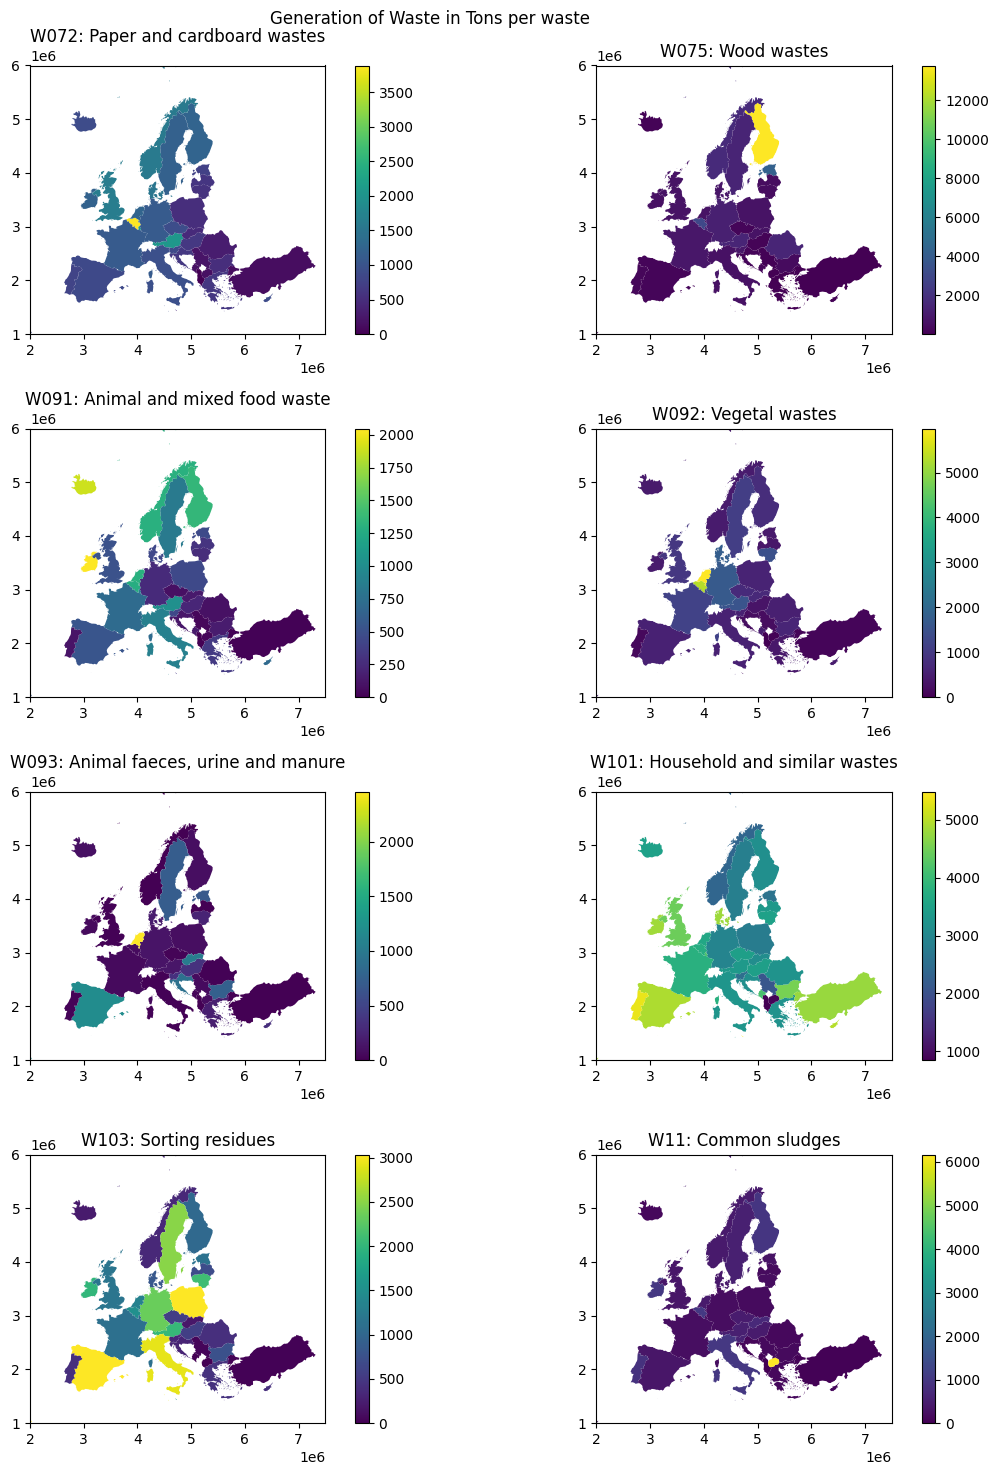

In [46]:
plot_production_per_country(biomass_wasgen, 'KG_HAB', 'waste')

### ⚠️ Future work:

* Sensitivity Analysis when choosing timeline
* Cross-check with evolution of waste production per country (maybe focus on countries that will increase production?

# Potential Action Points:

1. Focus on wood and vegetal wastes (W075 &  W092),
2. Lignocellulosic, wood and green biomass pathways
3. Include CCSU with Biogas conversion

# Cross check with Waste Treatment Capacity

In [62]:
wastreat = get_data('waste_treatment')
print(wastreat.shape)
wastreat.head()

Deleted DATAFLOW, with value ESTAT:ENV_WASTRT(1.0)
Deleted LAST UPDATE, with value 13/01/23 23:00:00
Deleted freq, with value A
(453228, 8)


,unit,hazard,wst_oper,waste,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,KG_HAB,HAZ,DSP_I,DSP_OTH,IS,2014,NaN,b
1,KG_HAB,HAZ,DSP_I,INC_OTH,AT,2004,2.0,NaN
2,KG_HAB,HAZ,DSP_I,INC_OTH,AT,2006,2.0,NaN
3,KG_HAB,HAZ,DSP_I,INC_OTH,AT,2008,NaN,c
4,KG_HAB,HAZ,DSP_I,INC_OTH,BE,2006,0.0,NaN


In [63]:
wastreat.OBS_FLAG.value_counts()

OBS_FLAG
z     63240
c      6588
b      1952
e      1272
bc      434
s       224
Name: count, dtype: int64

In [64]:
wastreat.isna().sum()

unit                0
hazard              0
wst_oper            0
waste               0
geo                 0
TIME_PERIOD         0
OBS_VALUE       70532
OBS_FLAG       379518
dtype: int64

In [65]:
70532/453228 *100

15.562145322001289

In [66]:
wastreat[wastreat.OBS_FLAG == "z"]

,unit,hazard,wst_oper,waste,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
2382,KG_HAB,HAZ,DSP_I,W061,AL,2010,NaN,z
2383,KG_HAB,HAZ,DSP_I,W061,AL,2012,NaN,z
2384,KG_HAB,HAZ,DSP_I,W061,AL,2014,NaN,z
2385,KG_HAB,HAZ,DSP_I,W061,AL,2016,NaN,z
2386,KG_HAB,HAZ,DSP_I,W061,AL,2018,NaN,z
...,...,...,...,...,...,...,...,...
448924,T,NHAZ,TRT,W077,XK,2012,NaN,z
448925,T,NHAZ,TRT,W077,XK,2014,NaN,z
448926,T,NHAZ,TRT,W077,XK,2016,NaN,z
448927,T,NHAZ,TRT,W077,XK,2018,NaN,z


In [67]:
@interact
def unique(x=list(wastreat.columns)): 
    print(f'Unique {x} values:')
    print(wastreat[x].unique())

interactive(children=(Dropdown(description='x', options=('unit', 'hazard', 'wst_oper', 'waste', 'geo', 'TIME_P…

In [69]:
aux = wastreat[(wastreat.unit == "T") & (wastreat.wst_oper.isin(['DSP_I']) & (wastreat.geo == "DE") & (wastreat.waste == "W092"))]
aux

,unit,hazard,wst_oper,waste,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
232270,T,HAZ,DSP_I,W092,DE,2010,NaN,z
232271,T,HAZ,DSP_I,W092,DE,2012,NaN,z
232272,T,HAZ,DSP_I,W092,DE,2014,NaN,z
232273,T,HAZ,DSP_I,W092,DE,2016,NaN,z
232274,T,HAZ,DSP_I,W092,DE,2018,NaN,z
232275,T,HAZ,DSP_I,W092,DE,2020,NaN,z
306877,T,HAZ_NHAZ,DSP_I,W092,DE,2010,8240.0,NaN
306878,T,HAZ_NHAZ,DSP_I,W092,DE,2012,10496.0,NaN
306879,T,HAZ_NHAZ,DSP_I,W092,DE,2014,9319.0,NaN
306880,T,HAZ_NHAZ,DSP_I,W092,DE,2016,7874.0,NaN


In [92]:
print(aux[aux.OBS_VALUE == 0].shape)
aux.isna().sum()

(56, 8)


unit            0
hazard          0
wst_oper        0
waste           0
geo             0
TIME_PERIOD     0
OBS_VALUE      13
OBS_FLAG       59
dtype: int64

In [97]:
aux = wastreat[(wastreat.unit == "T") & (wastreat.wst_oper.isin(['RCV_E', 'RCV_R_B']) & (wastreat.geo == "DE") & (wastreat.waste == "W075"))]
aux

,unit,hazard,wst_oper,waste,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
271804,T,HAZ,RCV_E,W075,DE,2010,1029468.0,NaN
271805,T,HAZ,RCV_E,W075,DE,2012,1362754.0,NaN
271806,T,HAZ,RCV_E,W075,DE,2014,1218162.0,NaN
271807,T,HAZ,RCV_E,W075,DE,2016,1186700.0,NaN
271808,T,HAZ,RCV_E,W075,DE,2018,1334464.0,NaN
271809,T,HAZ,RCV_E,W075,DE,2020,1388875.0,NaN
288094,T,HAZ,RCV_R_B,W075,DE,2010,60872.0,NaN
288095,T,HAZ,RCV_R_B,W075,DE,2012,99350.0,NaN
288096,T,HAZ,RCV_R_B,W075,DE,2014,NaN,c
288097,T,HAZ,RCV_R_B,W075,DE,2016,NaN,c


### Defining Treatment Operations from [Directive 2008/98/EC](https://eur-lex.europa.eu/eli/dir/2008/98/oj):

#### Disposal
‘disposal’ means any operation which is not recovery even where the operation has as a secondary consequence the reclamation of substances or energy. Annex I sets out a non-exhaustive list of disposal operations:
* D 1 Deposit into or on to land (e.g. landfill, etc.)
* D 2 Land treatment (e.g. biodegradation of liquid or sludgy discards in soils, etc.)
* D 3 Deep injection (e.g. injection of pumpable discards into wells, salt domes or naturally occurring repositories, etc.)
* D 4 Surface impoundment (e.g. placement of liquid or sludgy discards into pits, ponds or lagoons, etc.)
* D 5 Specially engineered landfill (e.g. placement into lined discrete cells which are capped and isolated from one another and the environment, etc.)
* D 6 Release into a water body except seas/oceans
* D 7 Release to seas/oceans including sea-bed insertion
* D 8 Biological treatment not specified elsewhere in this Annex which results in final compounds or mixtures which are discarded by means of any of the operations numbered D 1 to D 12
* D 9 Physico-chemical treatment not specified elsewhere in this Annex which results in final compounds or mixtures which are discarded by means of any of the operations numbered D 1 to D 12 (e.g. evaporation, drying, calcination, etc.)
* D 10 Incineration on land
* D 11 Incineration at sea (This operation is prohibited by EU legislation and international conventions)
* D 12 Permanent storage (e.g. emplacement of containers in a mine, etc.)
* D 13 Blending or mixing prior to submission to any of the operations numbered D 1 to D 12 (If there is no other D code appropriate, this can include preliminary operations prior to disposal including pre-processing such as, inter alia, sorting, crushing, compacting, pelletising, drying, shredding, conditioning or separating prior to submission to any of the operations numbered D1 to D12)
* D 14 Repackaging prior to submission to any of the operations numbered D 1 to D 13
* D 15 Storage pending any of the operations numbered D 1 to D 14 (excluding temporary storage, pending collection, on the site where the waste is produced) (Temporary storage means preliminary storage according to point (10) of Article 3.)

#### Recovery
‘recovery’ means any operation the principal result of which is waste serving a useful purpose by replacing other materials which would otherwise have been used to fulfil a particular function, or waste being prepared to fulfil that function, in the plant or in the wider economy. Annex II sets out a non-exhaustive list of recovery operations:
* R 1 Use principally as a fuel or other means to generate energy. This includes incineration facilities dedicated to the processing of municipal solid waste only where their energy  efficiency is equal to or above:
    * 0,60 for installations in operation and permitted in accordance with applicable Community legislation before 1 January 2009,
    * 0,65 for installations permitted after 31 December 2008, using the following formula: Energy efficiency = (Ep - (Ef + Ei))/(0,97 × (Ew + Ef)), in which: 
        - Ep means annual energy produced as heat or electricity. It is calculated with energy in the form of electricity being multiplied by 2,6 and heat produced for commercial use multiplied by 1,1 (GJ/year)
        - Ef means annual energy input to the system from fuels contributing to the production of steam (GJ/year)
        - Ew means annual energy contained in the treated waste calculated using the net calorific value of the waste (GJ/year)
        - Ei means annual energy imported excluding Ew and Ef (GJ/year)
        - 0,97 is a factor accounting for energy losses due to bottom ash and radiation.
        - This formula shall be applied in accordance with the reference document on Best Available Techniques for waste incineration
* R 2 Solvent reclamation/regeneration
* R 3 Recycling/reclamation of organic substances which are not used as solvents (including composting and other biological transformation processes) (This includes gasification and pyrolisis using the components as chemicals)
* R 4 Recycling/reclamation of metals and metal compounds
* R 5 Recycling/reclamation of other inorganic materials (This includes soil cleaning resulting in recovery of the soil and recycling of inorganic construction materials.)
* R 6 Regeneration of acids or bases
* R 7 Recovery of components used for pollution abatement
* R 8 Recovery of components from catalysts
* R 9 Oil re-refining or other reuses of oil
* R 10 Land treatment resulting in benefit to agriculture or ecological improvement
* R 11 Use of waste obtained from any of the operations numbered R 1 to R 10
* R 12 Exchange of waste for submission to any of the operations numbered R 1 to R 11 (If there is no other R code appropriate, this can include preliminary operations prior to recovery including pre-processing such as, inter alia, dismantling, sorting, crushing, compacting, pelletising, drying, shredding, conditioning, repackaging, separating, blending or mixing prior to submission to any of the operations numbered R1 to R11)
* R 13 Storage of waste pending any of the operations numbered R 1 to R 12 (excluding temporary storage, pending collection, on the site where the waste is produced) (Temporary storage means preliminary storage according to point (10) of Article 3) 


In [70]:
treatment_operations = {
'RCV_E': 'Recovery - energy recovery (R1)',
'RCV_R': 'Recovery - recycling',
'RCV_B': 'Recovery - backfilling',
'RCV_R_B': 'Recycling and backfilling (excluding energy recovery) (R2 to R11)',
'DSP_I': 'Disposal - incineration (D10)',
'DSP_L': 'Disposal - landfill (D1, D5, D12)',
'DSP_OTH': 'Disposal - other (D2-D4, D6-D7)',
'DSP_L_OTH': 'Landfill / disposal ( D1-D7, D12; DSP_D + DSP_OTH))'
}

recovery = ['RCV_R','RCV_E', 'RCV_B', 'RCV_R_B']
disposal = ['DSP_I','DSP_L', 'DSP_OTH', 'DSP_L_OTH']

In [71]:
# Data Congruence Analyisis

pivot_wastreat = pd.pivot_table(wastreat, values='OBS_VALUE', index=['unit', 'hazard', 'waste', 'geo', 'TIME_PERIOD'],
                       columns=['wst_oper'], aggfunc=np.sum)
pivot_wastreat = pivot_wastreat.reset_index()
print(pivot_wastreat[(pivot_wastreat.unit == "T") & pivot_wastreat.waste.isin(feedstocks)].shape)
pivot_wastreat[(pivot_wastreat.unit == "T") & pivot_wastreat.waste.isin(feedstocks)].isna().sum()

(1522, 14)


wst_oper
unit             0
hazard           0
waste            0
geo              0
TIME_PERIOD      0
DSP_I          212
DSP_L           12
DSP_L_OTH       16
DSP_OTH         22
RCV_B          238
RCV_E          209
RCV_R          206
RCV_R_B         36
TRT              2
dtype: int64

In [72]:
pivot_wastreat = pivot_wastreat.fillna(0)
pivot_wastreat

wst_oper,unit,hazard,waste,geo,TIME_PERIOD,DSP_I,DSP_L,DSP_L_OTH,DSP_OTH,RCV_B,RCV_E,RCV_R,RCV_R_B,TRT
0,KG_HAB,HAZ,DSP_OTH,AT,2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,KG_HAB,HAZ,DSP_OTH,AT,2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,KG_HAB,HAZ,DSP_OTH,AT,2008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KG_HAB,HAZ,DSP_OTH,BE,2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,KG_HAB,HAZ,DSP_OTH,BE,2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57937,T,NHAZ,W12_X_127NH,TR,2006,0.0,15019032.0,15303686.0,284654.0,0.0,0.0,0.0,1292217.0,16595903.0
57938,T,NHAZ,W12_X_127NH,TR,2008,0.0,20785680.0,20927273.0,141593.0,0.0,0.0,0.0,9662624.0,30589897.0
57939,T,NHAZ,W12_X_127NH,UK,2004,0.0,57054071.0,57054071.0,0.0,0.0,0.0,0.0,52469632.0,109523703.0
57940,T,NHAZ,W12_X_127NH,UK,2006,0.0,68323879.0,68323879.0,0.0,0.0,0.0,0.0,65490997.0,133814876.0


**Entries where Treatment != L + OTH + I + R + B + E**

In [73]:
pivot_wastreat[(pivot_wastreat.TRT < pivot_wastreat.DSP_L_OTH + pivot_wastreat.DSP_I +  pivot_wastreat.RCV_R_B + pivot_wastreat.RCV_E )]

wst_oper,unit,hazard,waste,geo,TIME_PERIOD,DSP_I,DSP_L,DSP_L_OTH,DSP_OTH,RCV_B,RCV_E,RCV_R,RCV_R_B,TRT
128,KG_HAB,HAZ,INC_OTH,ES,2006,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.000000e+00
132,KG_HAB,HAZ,INC_OTH,EU27_2020,2008,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.000000e+00
197,KG_HAB,HAZ,INC_OTH,UK,2004,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.000000e+00
304,KG_HAB,HAZ,TOTAL,AT,2010,8.0,6.0,6.0,0.0,0.0,11.0,24.0,24.0,4.800000e+01
313,KG_HAB,HAZ,TOTAL,BE,2010,15.0,90.0,90.0,0.0,0.0,20.0,196.0,196.0,3.200000e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57834,T,NHAZ,W12B,UK,2010,0.0,580474.0,18181733.0,17601259.0,307297.0,0.0,416953.0,724251.0,1.890598e+07
57873,T,NHAZ,W12_X_127NH,EU27_2020,2006,0.0,704280000.0,709790000.0,5510000.0,0.0,0.0,0.0,644990000.0,1.354770e+09
57874,T,NHAZ,W12_X_127NH,EU27_2020,2008,0.0,699330000.0,702600000.0,3270000.0,0.0,0.0,0.0,658550000.0,1.361140e+09
57876,T,NHAZ,W12_X_127NH,EU28,2006,0.0,772600000.0,778110000.0,5510000.0,0.0,0.0,0.0,710480000.0,1.488580e+09


In [74]:
57942 - 6057

51885

In [75]:
aux = pivot_wastreat[(pivot_wastreat.TRT > pivot_wastreat.DSP_L_OTH + pivot_wastreat.DSP_I + pivot_wastreat.RCV_R_B + pivot_wastreat.RCV_E)].copy()
aux['Total'] = aux.DSP_L_OTH + aux.DSP_I + aux.RCV_R_B + aux.RCV_E
print(aux.TRT.sum(), aux.Total.sum(), (aux.TRT.sum() - aux.Total.sum())/ aux.Total.sum() * 100)

46841449873.0 38398581019.0 21.987450134739053


In [76]:
# check proportion of disp and rcv in total

aux = pivot_wastreat[(pivot_wastreat.TRT == pivot_wastreat.DSP_L_OTH + pivot_wastreat.DSP_I + pivot_wastreat.RCV_R_B + pivot_wastreat.RCV_E)].copy()
aux['Prop_Disp'] = (aux.DSP_L_OTH + aux.DSP_I) / aux.TRT
aux['Prop_Recv'] = (aux.RCV_R_B + aux.RCV_E) / aux.TRT
print(aux['Prop_Disp'].mean(), aux['Prop_Recv'].mean())
congruent = aux.copy()

0.33260012325629457 0.6673998767437054


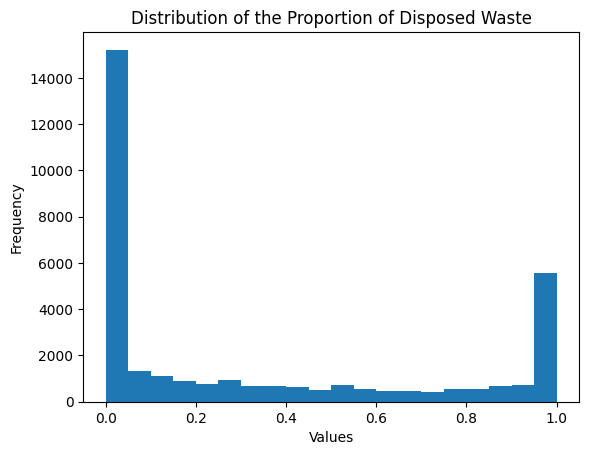

In [77]:
congruent['Prop_Disp'].plot.hist(bins=20)  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of the Proportion of Disposed Waste')
plt.show()

### ⚠️ Considerations:

* TRT = DSP_L_OTH + RCV_R_B + RCV_E
* Some variation in TRT
* TRT is many more times (6 057 entries, **10% of total entries**) bigger than the sum, then it is smaller (2 245 entries), aka data is usually missing in the individual sections and not in the TRT
* In the 6 057 entries the reported total Treatment amount is 20% higher the the total sum amount, while in the 2 245, the total sum is only 0.1% bigger than the total reported Treatment amount
* In 51 885 where data is congruent, the proportion of revovered waste is on average 2x higher (66%) then the disposal waste (33%)
* ⚠️ Indicates that although I'll use the values from disposals, the real data should be even higher: 33% * 20% of the total of the incongruent entries (although the distribuiton of the proporation is very closed to zero)

**Entries where L_OTH != L + OTH**

In [78]:
unequal = pivot_wastreat[(pivot_wastreat.DSP_L_OTH != pivot_wastreat.DSP_L + pivot_wastreat.DSP_OTH)]
unequal

wst_oper,unit,hazard,waste,geo,TIME_PERIOD,DSP_I,DSP_L,DSP_L_OTH,DSP_OTH,RCV_B,RCV_E,RCV_R,RCV_R_B,TRT
29,KG_HAB,HAZ,DSP_OTH,ES,2008,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2.000000e+00
73,KG_HAB,HAZ,DSP_OTH,NO,2004,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2.000000e+00
326,KG_HAB,HAZ,TOTAL,BG,2018,1.0,11.0,1893.0,1881.0,0.0,1.0,36.0,36.0,1.930000e+03
339,KG_HAB,HAZ,TOTAL,CZ,2008,6.0,7.0,8.0,0.0,0.0,6.0,0.0,61.0,8.000000e+01
364,KG_HAB,HAZ,TOTAL,EE,2004,0.0,4875.0,4876.0,0.0,0.0,32.0,0.0,361.0,5.270000e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57872,T,NHAZ,W12_X_127NH,EU27_2020,2004,0.0,781020000.0,784780000.0,3770000.0,0.0,0.0,0.0,520400000.0,1.305180e+09
57875,T,NHAZ,W12_X_127NH,EU28,2004,0.0,838070000.0,841830000.0,3770000.0,0.0,0.0,0.0,572870000.0,1.414700e+09
57927,T,NHAZ,W12_X_127NH,SE,2004,0.0,59859567.0,59870242.0,0.0,0.0,0.0,0.0,7947617.0,6.781786e+07
57932,T,NHAZ,W12_X_127NH,SI,2008,0.0,674840.0,674868.0,0.0,0.0,0.0,0.0,864282.0,1.539150e+06


In [120]:
sets = {
    'All' : unequal.copy(),
    'L_OTH > L + OTH': unequal[unequal.DSP_L_OTH > unequal.DSP_OTH + unequal.DSP_L].copy(),
    'Tons' : unequal[unequal.unit == 'T'].copy(),
    'Tons + Wood & Vegetal' : unequal[(unequal.unit == 'T') & unequal.waste.isin(['W075', 'W092'])].copy(),
    'Tons + Wood & Vegetal + L_OTH > L + OTH' : unequal[(unequal.unit == 'T') & unequal.waste.isin(['W075', 'W092']) & (unequal.DSP_L_OTH > unequal.DSP_OTH + unequal.DSP_L)].copy(),
}


@interact
def subsets(x=list(sets.keys())): 
    # Specify the columns you want to plot
    columns = ['unit', 'TIME_PERIOD', 'waste', 'geo']

    # Calculate the number of rows and columns for subplots
    num_plots = len(columns)
    num_rows = (num_plots + 1) // 2  # Round up if necessary
    num_cols = 2

    # Create a subplot grid
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 13))

    # Flatten the axs array if necessary
    if num_plots == 1:
        axs = axs.reshape(1, -1)

    # Iterate over the columns and plot value counts
    for i, col in enumerate(columns):
        # Calculate the subplot indices
        row_idx = i // num_cols
        col_idx = i % num_cols

        # Get the value counts of the column
        value_counts = sets[x][col].value_counts()

        # Create a bar plot for the value counts in the appropriate subplot
        axs[row_idx, col_idx].barh(value_counts.index.astype(str), value_counts.values)
        axs[row_idx, col_idx].set_ylabel('Values')
        axs[row_idx, col_idx].set_xlabel('Count')

        # Rotate x-axis labels by 45 degrees
        axs[row_idx, col_idx].tick_params(axis='x', labelrotation = 90)

        # Add labels
        axs[row_idx, col_idx].bar_label(axs[row_idx, col_idx].containers[0], label_type='edge')

        # Add title
        axs[row_idx, col_idx].set_title(f'No. of incongruences in {col}')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

interactive(children=(Dropdown(description='x', options=('All', 'L_OTH > L + OTH', 'Tons', 'Tons + Wood & Vege…

### ⚠️ Considerations:

* Most incongruences happen when L_OTH > L + OTH
* Will do L_OTH = L_OTH if L_OTH > L + OTH else L + OTH
* Will analyse Tons only

In [81]:
pivot_wastreat_tons = pivot_wastreat[pivot_wastreat.unit == "T"].copy()
pivot_wastreat_tons.DSP_L_OTH = pivot_wastreat_tons.apply(
    lambda x: x.DSP_L_OTH if x.DSP_L_OTH > x.DSP_L + x.DSP_OTH else x.DSP_L + x.DSP_OTH,
    axis=1
)
pivot_wastreat_tons.head()

wst_oper,unit,hazard,waste,geo,TIME_PERIOD,DSP_I,DSP_L,DSP_L_OTH,DSP_OTH,RCV_B,RCV_E,RCV_R,RCV_R_B,TRT
28971,T,HAZ,DSP_OTH,AT,2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28972,T,HAZ,DSP_OTH,AT,2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28973,T,HAZ,DSP_OTH,AT,2008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28974,T,HAZ,DSP_OTH,BE,2004,0.0,925.0,925.0,0.0,0.0,0.0,0.0,0.0,925.0
28975,T,HAZ,DSP_OTH,BE,2006,0.0,494.0,494.0,0.0,0.0,0.0,0.0,0.0,494.0


In [82]:
pivot_wastreat_tons[pivot_wastreat_tons.DSP_L_OTH < pivot_wastreat_tons.DSP_L + pivot_wastreat_tons.DSP_OTH]

wst_oper,unit,hazard,waste,geo,TIME_PERIOD,DSP_I,DSP_L,DSP_L_OTH,DSP_OTH,RCV_B,RCV_E,RCV_R,RCV_R_B,TRT


In [83]:
pivot_wastreat_tons[pivot_wastreat_tons.waste.isin(feedstocks)].isna().sum()

wst_oper
unit           0
hazard         0
waste          0
geo            0
TIME_PERIOD    0
DSP_I          0
DSP_L          0
DSP_L_OTH      0
DSP_OTH        0
RCV_B          0
RCV_E          0
RCV_R          0
RCV_R_B        0
TRT            0
dtype: int64

In [92]:
pivot_wastreat_tons['DISPOSED'] = pivot_wastreat_tons.DSP_I + pivot_wastreat_tons.DSP_L_OTH
biomass_wastreat = pivot_wastreat_tons[
    pivot_wastreat_tons.waste.isin(feedstocks) & (pivot_wastreat_tons.geo != 'EU27_2020') & (pivot_wastreat_tons.TIME_PERIOD >= 2010)
].groupby(
    ['waste', 'geo'],
    as_index = False
).DISPOSED.sum()

biomass_wastreat_geo = get_geometry(biomass_wastreat, countries)
biomass_wastreat_geo = biomass_wastreat_geo[biomass_wastreat_geo.geometry != None]
biomass_wastreat_geo.head()

,waste,geo,DISPOSED,geometry
0,W092,AL,0.0,"POLYGON ((5129579.170 2204098.752, 5148385.473..."
1,W092,AT,3426.0,"POLYGON ((4742889.368 2876362.725, 4783217.798..."
3,W092,BE,111708.0,"POLYGON ((3957506.818 3167694.476, 3964175.126..."
4,W092,BG,2292578.0,"POLYGON ((5363358.686 2390534.464, 5395245.631..."
5,W092,CY,184568.0,"POLYGON ((6342668.882 1629618.498, 6342926.802..."


In [93]:
biomass_wastreat_geo[(biomass_wastreat_geo.waste == "W075") & (biomass_wastreat_geo.geo == "DE")]

,waste,geo,DISPOSED,geometry


Vegetal wastes (countries):  ['RO', 'FR', 'BG', 'UK', 'HR'] Total Disposed Waste: 1.179541e+07 Tons
Vegetal wastes (values)   :  [4101912.0, 3377368.0, 2292578.0, 1446960.0, 576592.0]

Animal faeces, urine and manure (countries):  ['NL', 'BG', 'UK', 'FI', 'SK'] Total Disposed Waste: 1.249800e+07 Tons
Animal faeces, urine and manure (values)   :  [5189454.0, 3403650.0, 3178004.0, 436060.0, 290828.0]



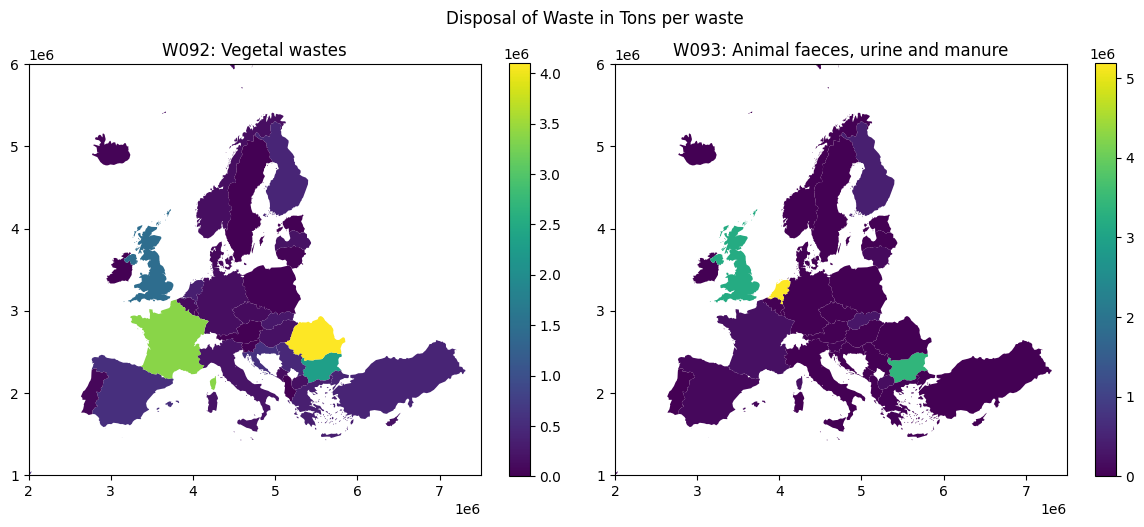

In [95]:
df = biomass_wastreat_geo
category = 'waste'
# Get the unique activities
categories = feedstocks.keys()

# Calculate the number of subplots needed
num_subplots = len(categories)

# Set the number of rows and columns for subplots layout
num_rows = num_subplots // 2
num_cols = num_subplots // num_rows

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5))

# Flatten the axes array if needed
if num_subplots > 1:
    axes = axes.flatten()

# Iterate over each activity and plot the corresponding bar plot
for i, cat in enumerate(categories):
    ax = axes[i] if num_subplots > 1 else axes  # Get the current subplot

    # Create the map plot
    aux = df[df[category] == cat]
    aux.plot(column='DISPOSED', legend=True, ax=ax)
    ax.set_xlim(2000000, 7500000)
    ax.set_ylim(1000000, 6000000)

    aux = aux.sort_values('DISPOSED', ascending=False)
    ax.set_title(f'{cat}: {feedstocks[cat]}')
    # Print top 5 countreis
    print(f'{feedstocks[cat]} (countries): ', list(aux.head().geo), f'Total Disposed Waste: {"{:e}".format(aux.head().DISPOSED.sum())} Tons')
    print(f'{feedstocks[cat]} (values)   : ', list(aux.head().DISPOSED))
    print()


fig.suptitle(f'Disposal of Waste in Tons per {category}')
# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### After choosing Wood and Vegetal Wastes:

df = biomass_wastreat_geo[biomass_wastreat_geo.waste.isin(['W075', "W092"])]

df = pd.pivot_table(df, values='DISPOSED', index=['geo', 'geometry'],
                       columns=['waste'], aggfunc=np.sum).reset_index()
df['OBS_VALUE'] = df.W075 + df.W092
df.head()

Countries:  ['UK', 'FR', 'RO', 'BE', 'BG'] Total Disposed Waste: 2.424897e+07 Tons
Values   :  [7614035.0, 7279608.0, 4125413.0, 2856568.0, 2373347.0]



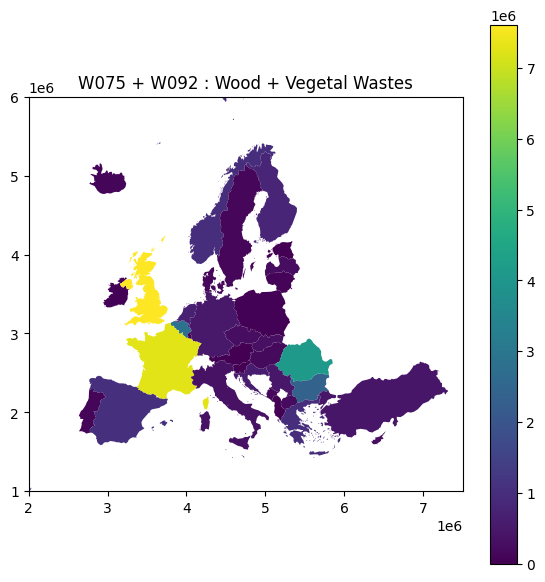

In [128]:
# Create the map plot
df = gpd.GeoDataFrame(df)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
df.plot(column='OBS_VALUE', legend=True, ax=ax)
ax.set_xlim(2000000, 7500000)
ax.set_ylim(1000000, 6000000)

df = df.sort_values('OBS_VALUE', ascending=False)
ax.set_title("W075 + W092 : Wood + Vegetal Wastes")

print(f'Countries: ', list(df.head().geo), f'Total Disposed Waste: {"{:e}".format(df.head().OBS_VALUE.sum())} Tons')
print(f'Values   : ', list(df.head().OBS_VALUE))
print()

# Show the plot
plt.show()

In [135]:
output = df.head().copy().reset_index(drop = True)
output.loc[:, 'MonthlyAverage'] = df.OBS_VALUE / 10 /12
output.loc[:, 'AnnualAverage'] = df.OBS_VALUE / 10
output.loc[:, 'W075_MonthlyAverage'] = df.W075 / 10 /12
output.loc[:, 'W075_AnnualAverage'] = df.W075 / 10
output.loc[:, 'W092_MonthlyAverage'] = df.W092 / 10 /12
output.loc[:, 'W092_AnnualAverage'] = df.W092 / 10
output

waste,geo,geometry,W075,W092,OBS_VALUE,MonthlyAverage,AnnualAverage,W075_MonthlyAverage,W075_AnnualAverage,W092_MonthlyAverage,W092_AnnualAverage
0,UK,"MULTIPOLYGON (((3643416.574 3198789.397, 36397...",6167075.0,1446960.0,7614035.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,FR,"MULTIPOLYGON (((9954236.116 -3059379.316, 9961...",3902240.0,3377368.0,7279608.0,186.758333,2241.1,158.208333,1898.5,28.550000,342.6
2,RO,"POLYGON ((5616141.550 2872864.277, 5661531.895...",23501.0,4101912.0,4125413.0,23804.733333,285656.8,22873.833333,274486.0,930.900000,11170.8
3,BE,"POLYGON ((3957506.818 3167694.476, 3964175.126...",2744860.0,111708.0,2856568.0,19777.891667,237334.7,673.075000,8076.9,19104.816667,229257.8
4,BG,"POLYGON ((5363358.686 2390534.464, 5395245.631...",80769.0,2292578.0,2373347.0,2358.350000,28300.2,820.283333,9843.4,1538.066667,18456.8


In [149]:
wasgen[(wasgen.geo =='FR') & (wasgen.waste == "W092") & (wasgen.unit == "T")].groupby('nace_r2').OBS_VALUE.sum().sort_values()

nace_r2
E36_E37_E39           0.0
G4677                 0.0
C19                1346.0
B                  2804.0
A                 28470.0
C26-C30           48724.0
C24_C25           49404.0
C23               49712.0
C31-C33           55236.0
C16               75256.0
C13-C15           77882.0
D                122964.0
C17_C18          366960.0
C20-C22          723962.0
E               2587148.0
E38             2587148.0
F               7432644.0
G-U_X_G4677    13412178.0
C10-C12        14753654.0
C              16202140.0
EP_HH          47626516.0
TOTAL_HH       87414862.0
Name: OBS_VALUE, dtype: float64

In [27]:
wastreat[(wastreat.geo=='PT') & (wastreat.waste=='W075')]

,unit,hazard,wst_oper,waste,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
4159,KG_HAB,HAZ,DSP_I,W075,PT,2010,0.0,NaN
4160,KG_HAB,HAZ,DSP_I,W075,PT,2012,0.0,NaN
4161,KG_HAB,HAZ,DSP_I,W075,PT,2014,0.0,NaN
4162,KG_HAB,HAZ,DSP_I,W075,PT,2016,0.0,NaN
4163,KG_HAB,HAZ,DSP_I,W075,PT,2018,0.0,NaN
...,...,...,...,...,...,...,...,...
448317,T,NHAZ,TRT,W075,PT,2012,190813.0,NaN
448318,T,NHAZ,TRT,W075,PT,2014,144688.0,NaN
448319,T,NHAZ,TRT,W075,PT,2016,129304.0,NaN
448320,T,NHAZ,TRT,W075,PT,2018,172825.0,NaN


# Cross Check with Imports/ Exports

In [73]:
wastrade = get_data('waste_trade')
wastrade.shape
wastrade.head()

Deleted DATAFLOW, with value ESTAT:ENV_WASTRDMP(1.0)
Deleted LAST UPDATE, with value 24/05/22 23:00:00
Deleted freq, with value A
Deleted OBS_FLAG, with value nan


,stk_flow,rawmat,partner,unit,geo,TIME_PERIOD,OBS_VALUE
0,EXP,GLAS,AD,T,ES,2011,0.0
1,EXP,GLAS,AD,T,ES,2016,0.0
2,EXP,GLAS,AD,T,ES,2017,2.0
3,EXP,GLAS,AD,T,ES,2018,3.0
4,EXP,GLAS,AD,T,ES,2019,1.0


In [74]:
wastrade.isna().sum()

stk_flow          0
rawmat            0
partner        2524
unit              0
geo               0
TIME_PERIOD       0
OBS_VALUE         0
dtype: int64

In [75]:
wastrade.rawmat.unique()

array(['GLAS', 'MIN', 'MT', 'MT_FER', 'MT_NFER', 'MT_NFER_CAN',
       'MT_NFER_OTH', 'MT_NFER_PRE', 'NSP', 'ORG', 'ORG_ANI', 'ORG_VEG',
       'PAPER', 'PLAST', 'PLAST_RUB', 'RUB', 'TEXT', 'TEXT_NTL',
       'TEXT_SYN', 'TOTAL', 'WD'], dtype=object)

In [76]:
wastrade.geo.unique()

array(['ES', 'EU27_2020', 'FR', 'BE', 'CZ', 'DE', 'IE', 'IT', 'MT', 'SE',
       'SK', 'EL', 'LU', 'PT', 'DK', 'FI', 'NL', 'PL', 'AT', 'HR', 'HU',
       'SI', 'EE', 'LT', 'LV', 'RO', 'BG', 'CY'], dtype=object)

In [77]:
trade_wastes = [
    #'ORG_ANI', 
    'ORG_VEG',
    #'PAPER',
    #'TEXT_NTL',
    #'TEXT_SYN',
    'WD']

In [78]:
countries = countries.rename(columns={'NUTS_ID': 'geo'})

In [79]:
wastrade.stk_flow.unique()

array(['EXP', 'IMP'], dtype=object)

In [80]:
wastrade = gpd.GeoDataFrame(wastrade.merge(countries[['geo', 'geometry']], how="left", on="geo"))

wastrade.head()

,stk_flow,rawmat,partner,unit,geo,TIME_PERIOD,OBS_VALUE,geometry
0,EXP,GLAS,AD,T,ES,2011,0.0,"MULTIPOLYGON (((3828319.814 1893178.953, 38317..."
1,EXP,GLAS,AD,T,ES,2016,0.0,"MULTIPOLYGON (((3828319.814 1893178.953, 38317..."
2,EXP,GLAS,AD,T,ES,2017,2.0,"MULTIPOLYGON (((3828319.814 1893178.953, 38317..."
3,EXP,GLAS,AD,T,ES,2018,3.0,"MULTIPOLYGON (((3828319.814 1893178.953, 38317..."
4,EXP,GLAS,AD,T,ES,2019,1.0,"MULTIPOLYGON (((3828319.814 1893178.953, 38317..."


In [81]:
wastrade.isna().sum()

stk_flow            0
rawmat              0
partner          2524
unit                0
geo                 0
TIME_PERIOD         0
OBS_VALUE           0
geometry       153830
dtype: int64

In [82]:
wastrade.columns

Index(['stk_flow', 'rawmat', 'partner', 'unit', 'geo', 'TIME_PERIOD',
       'OBS_VALUE', 'geometry'],
      dtype='object')

## Plotting out exports

In [83]:
df = wastrade[wastrade.rawmat.isin(trade_wastes) & \
             (wastrade.stk_flow == "EXP") & \
             (~wastrade.geometry.isna())]

df = df.pivot(columns="unit", values="OBS_VALUE", index=['stk_flow', 'rawmat', 'partner', 'geo', 'TIME_PERIOD', 'geometry'])

df = df.reset_index()
df.head()

unit,stk_flow,rawmat,partner,geo,TIME_PERIOD,geometry,T,THS_EUR
0,EXP,ORG_VEG,AD,NL,2009,"MULTIPOLYGON (((4113226.333 3371154.950, 41159...",4.0,9.9
1,EXP,ORG_VEG,AE,AT,2006,"POLYGON ((4742889.368 2876362.725, 4783217.798...",0.0,0.9
2,EXP,ORG_VEG,AE,BE,2012,"POLYGON ((3957506.818 3167694.476, 3964175.126...",0.0,0.0
3,EXP,ORG_VEG,AE,BE,2013,"POLYGON ((3957506.818 3167694.476, 3964175.126...",20.0,5.0
4,EXP,ORG_VEG,AE,BE,2014,"POLYGON ((3957506.818 3167694.476, 3964175.126...",37.0,23.1


In [84]:
df = gpd.GeoDataFrame(df.groupby(['rawmat', 'geo'], as_index = False).agg({'T':'sum', 'THS_EUR':'sum', 'geometry':'first'}))
df.head()

unit,rawmat,geo,T,THS_EUR,geometry
0,ORG_VEG,AT,2461104.0,462668.2,"POLYGON ((4742889.368 2876362.725, 4783217.798..."
1,ORG_VEG,BE,5269399.0,928813.9,"POLYGON ((3957506.818 3167694.476, 3964175.126..."
2,ORG_VEG,BG,1419946.0,319092.4,"POLYGON ((5363358.686 2390534.464, 5395245.631..."
3,ORG_VEG,CY,2596.0,249.0,"POLYGON ((6342668.882 1629618.498, 6342926.802..."
4,ORG_VEG,CZ,515148.0,43654.5,"POLYGON ((4645979.160 3093185.023, 4656689.778..."


In [85]:
df.dtypes

unit
rawmat        object
geo           object
T            float64
THS_EUR      float64
geometry    geometry
dtype: object

In [86]:
df.loc[:,"Price"] = df.THS_EUR / df['T']
df.head()

unit,rawmat,geo,T,THS_EUR,geometry,Price
0,ORG_VEG,AT,2461104.0,462668.2,"POLYGON ((4742889.368 2876362.725, 4783217.798...",0.187992
1,ORG_VEG,BE,5269399.0,928813.9,"POLYGON ((3957506.818 3167694.476, 3964175.126...",0.176266
2,ORG_VEG,BG,1419946.0,319092.4,"POLYGON ((5363358.686 2390534.464, 5395245.631...",0.224722
3,ORG_VEG,CY,2596.0,249.0,"POLYGON ((6342668.882 1629618.498, 6342926.802...",0.095917
4,ORG_VEG,CZ,515148.0,43654.5,"POLYGON ((4645979.160 3093185.023, 4656689.778...",0.084742


ORG_VEG Volume ['DE', 'BE', 'NL', 'FR', 'AT']
ORG_VEG Price [0.09242684459295342, 0.17626562346104366, 0.24301095809833978, 0.13636708979921358, 0.18799213686215618]
WD Volume ['DE', 'AT', 'FR', 'BE', 'PL']
WD Price [0.09665055520811683, 0.09204718712020608, 0.06217325821885134, 0.0894201765358822, 0.11048292233279404]


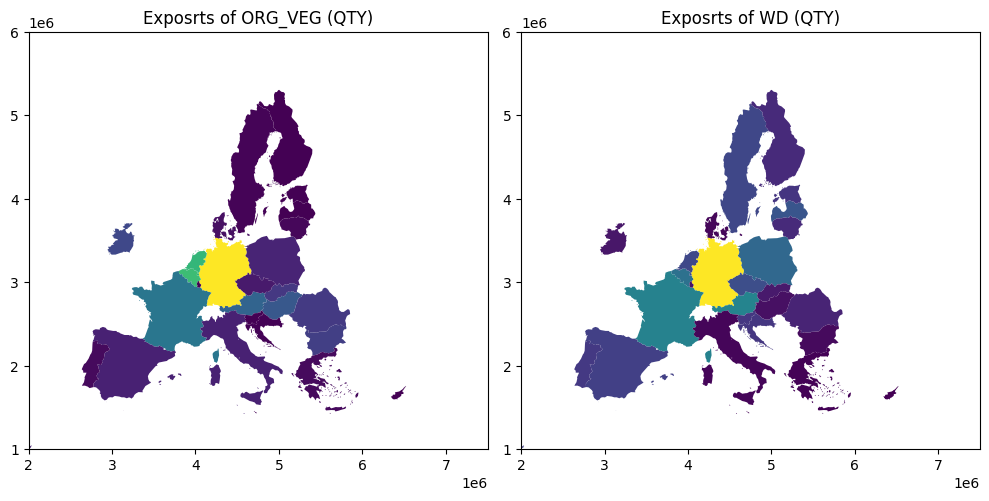

In [90]:
# Get the unique activities
wastes = trade_wastes

# Calculate the number of subplots needed
num_subplots = len(wastes)

# Set the number of rows and columns for subplots layout
try:
    num_rows = num_subplots // 2
    num_cols = num_subplots // num_rows
except:
    num_rows  =1
    num_cols = 1
# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Flatten the axes array if needed
if num_subplots > 1:
    axes = axes.flatten()

# Iterate over each activity and plot the corresponding bar plot
for i, waste in enumerate(wastes):
    ax = axes[i] if num_subplots > 1 else axes  # Get the current subplot
    
    plot_df = df[df['rawmat'] == waste].sort_values("T", ascending=False)
    print(f"{waste} Volume", plot_df.geo.head().to_list())
    print(f"{waste} Price",plot_df.Price.head().to_list())
    # Create the map plot
    plot_df.plot(column='T', legend=False, ax=ax)
    ax.set_xlim(2000000, 7500000)
    ax.set_ylim(1000000, 6000000)

    # Set the title and axes labels
    ax.set_title(f'Exposrts of {waste} (QTY)')


# Adjust the spacing between subplots
plt.tight_layout()


# Show the plot
plt.show()

## Plotting out Imports

In [338]:
df = wastrade[wastrade.rawmat.isin(trade_wastes) & \
             (wastrade.stk_flow == "IMP") & \
             (wastrade.unit == 'THS_EUR') & \
             (~wastrade.geometry.isna())]

df = gpd.GeoDataFrame(df.groupby(['rawmat', 'geo'], as_index = False).agg({'OBS_VALUE':'sum', 'geometry':'first'}))

df.head()

,rawmat,geo,OBS_VALUE,geometry
0,ORG_ANI,AT,36770.6,"POLYGON ((4742889.368 2876362.725, 4783217.798..."
1,ORG_ANI,BE,1104953.5,"POLYGON ((3957506.818 3167694.476, 3964175.126..."
2,ORG_ANI,BG,1683.4,"POLYGON ((5363358.686 2390534.464, 5395245.631..."
3,ORG_ANI,CY,192.4,"POLYGON ((6342668.882 1629618.498, 6342926.802..."
4,ORG_ANI,CZ,162442.7,"POLYGON ((4645979.160 3093185.023, 4656689.778..."


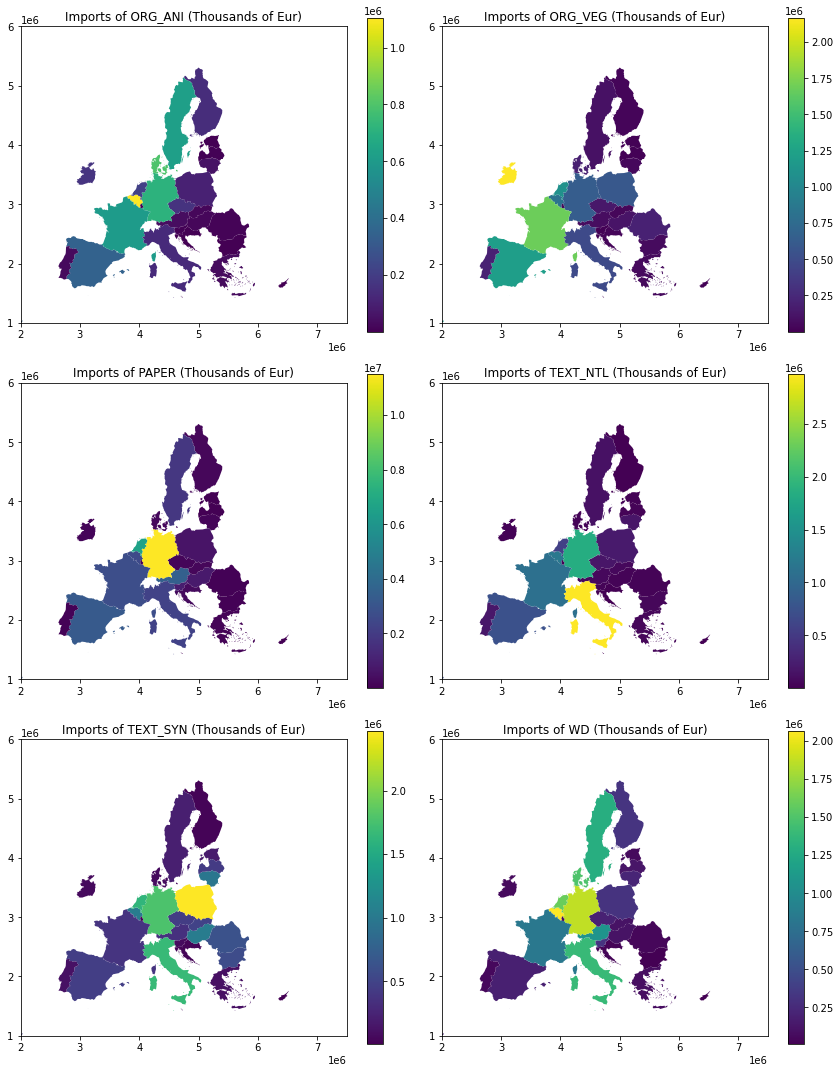

In [340]:
# Get the unique activities
wastes = trade_wastes

# Calculate the number of subplots needed
num_subplots = len(wastes)

# Set the number of rows and columns for subplots layout
num_rows = num_subplots // 2
num_cols = num_subplots // num_rows

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 15))

# Flatten the axes array if needed
if num_subplots > 1:
    axes = axes.flatten()

# Iterate over each activity and plot the corresponding bar plot
for i, waste in enumerate(wastes):
    ax = axes[i] if num_subplots > 1 else axes  # Get the current subplot
    
    # Create the map plot
    df[df['rawmat'] == waste].plot(column='OBS_VALUE', legend=True, ax=ax)
    ax.set_xlim(2000000, 7500000)
    ax.set_ylim(1000000, 6000000)

    # Set the title and axes labels
    ax.set_title(f'Imports of {waste} (Thousands of Eur)')


# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Food Waste Analysis

In [7]:
fw = get_data('food_waste')

fw.head()

Deleted DATAFLOW, with value ESTAT:ENV_WASFW(1.0)
Deleted LAST UPDATE, with value 06/03/23 23:00:00
Deleted freq, with value A
Deleted wst_oper, with value COL
Deleted waste, with value W091_092_101_FD
Deleted TIME_PERIOD, with value 2020


,nace_r2,unit,geo,OBS_VALUE,OBS_FLAG
0,A01_A03_FOOD,KG_HAB,AT,2,NaN
1,A01_A03_FOOD,KG_HAB,BE,3,NaN
2,A01_A03_FOOD,KG_HAB,BG,33,NaN
3,A01_A03_FOOD,KG_HAB,CY,49,d
4,A01_A03_FOOD,KG_HAB,CZ,3,NaN


# Other Analysis

### Compare with Eurostat package

In [68]:
import eurostat
df = eurostat.get_data_df('ENV_WASGEN')
df.head()

,freq,unit,hazard,nace_r2,waste,geo\TIME_PERIOD,2004,2006,2008,2010,2012,2014,2016,2018,2020
0,A,KG_HAB,HAZ,A,PRIM,AT,NaN,NaN,NaN,9.0,1.0,1.0,NaN,1.0,1.0
1,A,KG_HAB,HAZ,A,PRIM,BA,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2,A,KG_HAB,HAZ,A,PRIM,BE,NaN,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0
3,A,KG_HAB,HAZ,A,PRIM,BG,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0
4,A,KG_HAB,HAZ,A,PRIM,CY,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0


In [90]:
df = df.rename(columns={'geo\\TIME_PERIOD':'geo'})
#df = df.drop('freq', axis = 1)
# Specify the columns to be melted into the 'OBS_VALUE' and 'YEAR' columns
id_vars = ['unit', 'hazard', 'nace_r2', 'waste', 'geo']

# Use 'melt()' to transform the columns
melted_df = pd.melt(df, id_vars=id_vars, var_name='TIME_PERIOD', value_name='OBS_VALUE')

# Show the transformed DataFrame
melted_df

,unit,hazard,nace_r2,waste,geo,TIME_PERIOD,OBS_VALUE
0,KG_HAB,HAZ,A,PRIM,AT,2004,NaN
1,KG_HAB,HAZ,A,PRIM,BA,2004,NaN
2,KG_HAB,HAZ,A,PRIM,BE,2004,NaN
3,KG_HAB,HAZ,A,PRIM,BG,2004,NaN
4,KG_HAB,HAZ,A,PRIM,CY,2004,NaN
...,...,...,...,...,...,...,...
2142121,T,NHAZ,TOTAL_HH,W13,SE,2020,NaN
2142122,T,NHAZ,TOTAL_HH,W13,SI,2020,NaN
2142123,T,NHAZ,TOTAL_HH,W13,SK,2020,NaN
2142124,T,NHAZ,TOTAL_HH,W13,TR,2020,NaN


In [93]:
melted_df.isna().sum()

unit                0
hazard              0
nace_r2             0
waste               0
geo                 0
TIME_PERIOD         0
OBS_VALUE      839096
dtype: int64

In [76]:
melted_df.equals(wasgen.drop('OBS_FLAG', axis=1))

False

In [77]:
wasgen.drop('OBS_FLAG', axis=1).isin(melted_df).all().all()

False

In [92]:
df1 = wasgen.drop('OBS_FLAG', axis=1).sort_values(['TIME_PERIOD', 'geo'])
df1[~df1.isin(melted_df).all(axis=1) & (df1.waste=='PRIM')]

,unit,hazard,nace_r2,waste,geo,TIME_PERIOD,OBS_VALUE
0,KG_HAB,HAZ,A,PRIM,AT,2010,9.0
10626,KG_HAB,HAZ,B,PRIM,AT,2010,1.0
21508,KG_HAB,HAZ,C,PRIM,AT,2010,41.0
32574,KG_HAB,HAZ,C10-C12,PRIM,AT,2010,0.0
43545,KG_HAB,HAZ,C13-C15,PRIM,AT,2010,0.0
...,...,...,...,...,...,...,...
1417278,T,NHAZ,EP_HH,PRIM,XK,2020,379391.0
1427857,T,NHAZ,F,PRIM,XK,2020,4441.0
1439055,T,NHAZ,G-U_X_G4677,PRIM,XK,2020,79317.0
1450370,T,NHAZ,G4677,PRIM,XK,2020,0.0


In [83]:
df1.isin(melted_df).all(axis=1)

0          False
1          False
2          False
3          False
4          False
           ...  
1472813    False
1472814    False
1472815    False
1472816    False
1472817    False
Length: 1472818, dtype: bool

##### ⚠️  Eurostat package doesn't seem to work well

### Flags

Flags meaning can be found [here](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Tutorial:Symbols_and_abbreviations#Statistical_symbols.2C_abbreviations_and_units_of_measurement) 

* -(or z): not applicable
* :	   : not available (1)
* 0	   : real zero
* 0n	   : less than half of the final digit shown and greater than real zero
* | or b : break in time series
* c	   : confidential
* d	   : definition differs, see metadata
* e	   : estimated value
* f	   : forecast
* n	   : not significant
* p	   : provisional value
* u	   : low reliability (2)

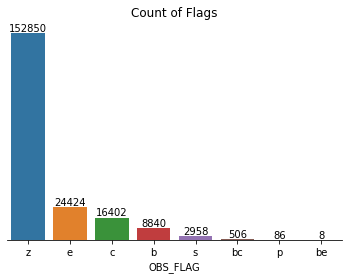

In [62]:
ax = sns.countplot(x='OBS_FLAG', data=wasgen,
                   # order from usages
                   order=wasgen.OBS_FLAG.value_counts().index)

# add labels
ax.bar_label(ax.containers[0])

# remove y axis
ax.get_yaxis().set_visible(False)

# remove frame
sns.despine(left=True)

ax.set_title("Count of Flags")

plt.show()

In [66]:
# most flagged items are null
wasgen[~wasgen.OBS_VALUE.isna() & ~wasgen.OBS_FLAG.isna()].groupby('OBS_FLAG').OBS_VALUE.nunique()

OBS_FLAG
b     2242
be       4
e     5971
p       36
s      455
Name: OBS_VALUE, dtype: int64

In [74]:
wasgen

,unit,hazard,nace_r2,waste,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,KG_HAB,HAZ,A,PRIM,AT,2010,9.0,NaN
1,KG_HAB,HAZ,A,PRIM,AT,2012,1.0,NaN
2,KG_HAB,HAZ,A,PRIM,AT,2014,1.0,NaN
3,KG_HAB,HAZ,A,PRIM,AT,2016,NaN,c
4,KG_HAB,HAZ,A,PRIM,AT,2018,1.0,NaN
...,...,...,...,...,...,...,...,...
1472813,T,NHAZ,TOTAL_HH,W13,TR,2006,0.0,NaN
1472814,T,NHAZ,TOTAL_HH,W13,TR,2008,0.0,NaN
1472815,T,NHAZ,TOTAL_HH,W13,UK,2004,10064.0,NaN
1472816,T,NHAZ,TOTAL_HH,W13,UK,2006,57686.0,NaN


## Joining with Geo

In [6]:
countries.groupby(['NUTS_ID', 'CNTR_CODE', 'FID', 'NUTS_NAME'], as_index=False).NAME_LATN.count()

,NUTS_ID,CNTR_CODE,FID,NUTS_NAME,NAME_LATN
0,AL,AL,AL,Shqipëria,1
1,AT,AT,AT,Österreich,1
2,BE,BE,BE,Belgique/België,1
3,BG,BG,BG,България,1
4,CH,CH,CH,Schweiz/Suisse/Svizzera,1
5,CY,CY,CY,Κύπρος,1
6,CZ,CZ,CZ,Česko,1
7,DE,DE,DE,Deutschland,1
8,DK,DK,DK,Danmark,1
9,EE,EE,EE,Eesti,1


In [7]:
wasgen_v0 = wasgen.copy()

In [8]:
wasgen = gpd.GeoDataFrame(wasgen_v0.merge(countries[['NUTS_ID', 'geometry']].rename(columns={'NUTS_ID':'geo'}), 
                                          on='geo', how='left'))
wasgen.head()

,unit,hazard,nace_r2,waste,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,geometry
0,KG_HAB,HAZ,A,PRIM,AT,2010,9.0,NaN,"POLYGON ((4742889.368 2876362.725, 4783217.798..."
1,KG_HAB,HAZ,A,PRIM,AT,2012,1.0,NaN,"POLYGON ((4742889.368 2876362.725, 4783217.798..."
2,KG_HAB,HAZ,A,PRIM,AT,2014,1.0,NaN,"POLYGON ((4742889.368 2876362.725, 4783217.798..."
3,KG_HAB,HAZ,A,PRIM,AT,2016,NaN,c,"POLYGON ((4742889.368 2876362.725, 4783217.798..."
4,KG_HAB,HAZ,A,PRIM,AT,2018,1.0,NaN,"POLYGON ((4742889.368 2876362.725, 4783217.798..."


In [9]:
wasgen[wasgen.geometry.isna()].geo.unique()

array(['BA', 'EU27_2020', 'EU28', 'XK'], dtype=object)

##### ⚠️  BA (Bosnia) and XK (Kosovo) don't have geometry

# Understanding the Data

In [10]:
wasgen.geo.unique()

array(['AT', 'BA', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES',
       'EU27_2020', 'EU28', 'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT',
       'LI', 'LT', 'LU', 'LV', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT',
       'RO', 'RS', 'SE', 'SI', 'SK', 'TR', 'UK', 'XK', 'AL'], dtype=object)

### Waste Per Country

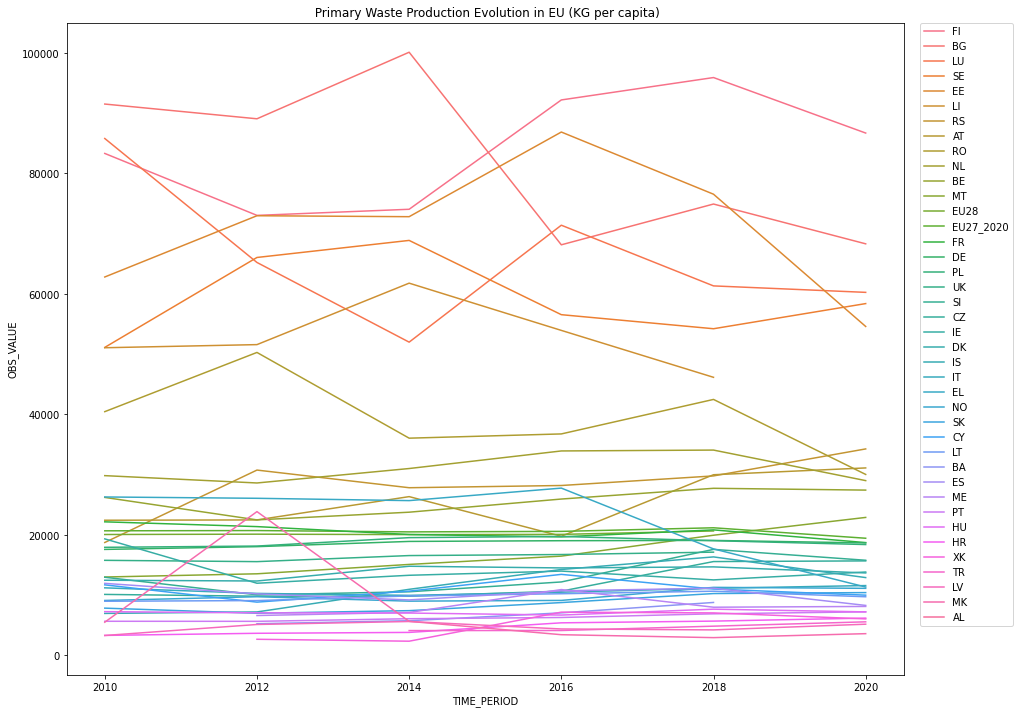

In [10]:
df = wasgen[(wasgen.unit == 'KG_HAB') & (wasgen.waste == 'PRIM')] \
    .groupby(['geo', 'TIME_PERIOD'], as_index=False).OBS_VALUE.sum()

fig, ax =plt.subplots(figsize=(15,12))

plt.title(" Primary Waste Production Evolution in EU (KG per capita)")

# order countries by last value
sorted_countries = df.sort_values(['TIME_PERIOD'], ascending=False).drop_duplicates('geo', keep='first') \
                     .sort_values('OBS_VALUE', ascending=False).geo

sns.lineplot(df, x='TIME_PERIOD', y='OBS_VALUE', hue = 'geo', hue_order=sorted_countries, ax=ax)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


plt.show()

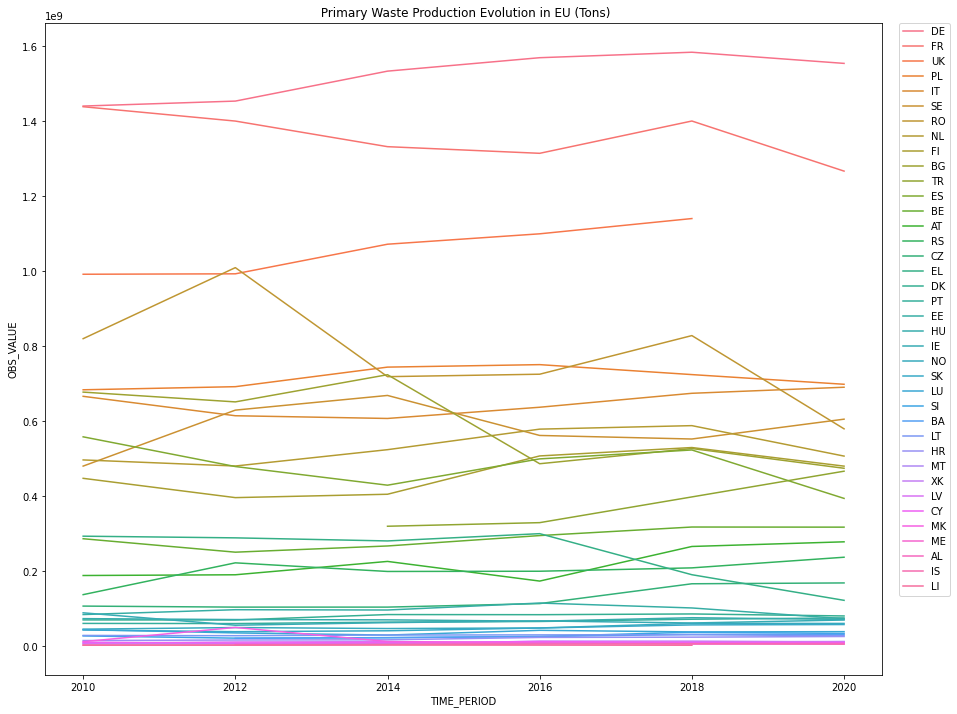

In [152]:
df = wasgen[(wasgen.unit == 'T') & (~wasgen.geo.isin(['EU28', 'EU27_2020'])) & (wasgen.waste == 'PRIM')] \
    .groupby(['geo', 'TIME_PERIOD'], as_index=False).OBS_VALUE.sum()

fig, ax =plt.subplots(figsize=(15,12))

plt.title(" Primary Waste Production Evolution in EU (Tons)")

# order countries by last value
sorted_countries = df.sort_values(['TIME_PERIOD'], ascending=False).drop_duplicates('geo', keep='first') \
                     .sort_values('OBS_VALUE', ascending=False).geo

sns.lineplot(df, x='TIME_PERIOD', y='OBS_VALUE', hue = 'geo', hue_order=sorted_countries, ax=ax)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


plt.show()

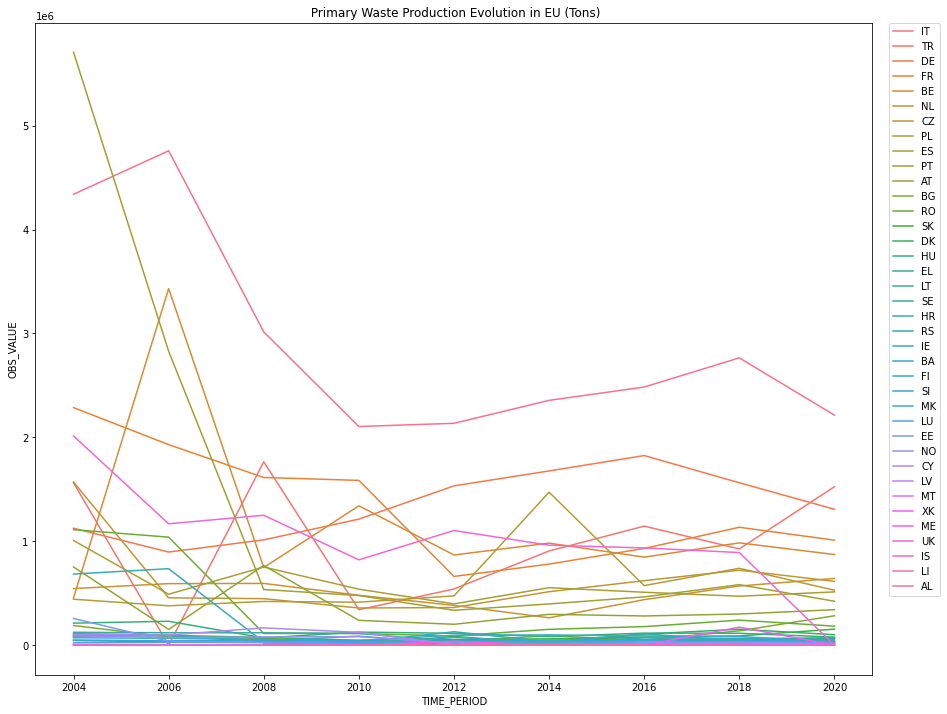

In [157]:
df = wasgen[(wasgen.unit == 'T') & (~wasgen.geo.isin(['EU28', 'EU27_2020'])) & (wasgen.waste == 'W076')] \
    .groupby(['geo', 'TIME_PERIOD'], as_index=False).OBS_VALUE.sum()

fig, ax =plt.subplots(figsize=(15,12))

plt.title(" Primary Waste Production Evolution in EU (Tons)")

# order countries by last value
sorted_countries = df.sort_values(['TIME_PERIOD'], ascending=False).drop_duplicates('geo', keep='first') \
                     .sort_values('OBS_VALUE', ascending=False).geo

sns.lineplot(df, x='TIME_PERIOD', y='OBS_VALUE', hue = 'geo', hue_order=sorted_countries, ax=ax)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


plt.show()

Text(0.5, 1.0, 'Animal & Food Waste Gen in the European Union (KG_HAB)')

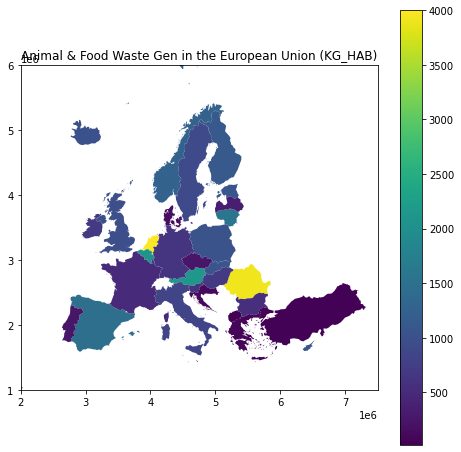

In [13]:
units = ['KG_HAB', 'T']
unit = units[0]
df = wasgen[(wasgen.unit == unit) & (~wasgen.geo.isin(['EU28', 'EU27_2020'])) & (wasgen.waste == 'W09')] \
    .groupby(['geo', 'TIME_PERIOD'], as_index=False).agg({'OBS_VALUE':'sum', 'geometry' : 'first'}) \
    .sort_values(['TIME_PERIOD'], ascending=False).drop_duplicates('geo', keep='first') \
    .sort_values('OBS_VALUE', ascending=False)

df = gpd.GeoDataFrame(df)

ax = df.plot(column='OBS_VALUE', legend=True, figsize=(8, 8))
ax.set_xlim(2000000, 7500000)
ax.set_ylim(1000000, 6000000)
ax.set_title(f'Animal & Food Waste Gen in the European Union ({unit})')

Text(0.5, 1.0, 'Animal & Food Waste Gen in the European Union (Tons)')

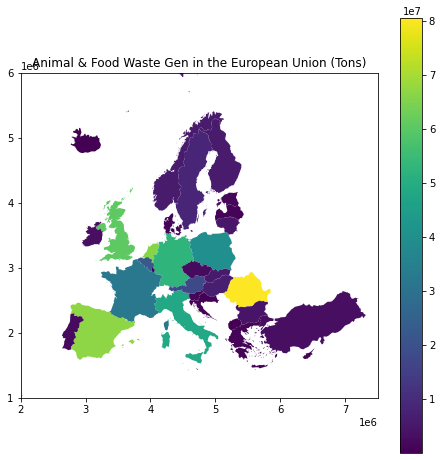

In [209]:
df = wasgen[(wasgen.unit == 'T') & (~wasgen.geo.isin(['EU28', 'EU27_2020'])) & (wasgen.waste == 'W09')] \
    .groupby(['geo', 'TIME_PERIOD'], as_index=False).agg({'OBS_VALUE':'sum', 'geometry' : 'first'}) \
    .sort_values(['TIME_PERIOD'], ascending=False).drop_duplicates('geo', keep='first') \
    .sort_values('OBS_VALUE', ascending=False)

df = gpd.GeoDataFrame(df)

ax = df.plot(column='OBS_VALUE', legend=True, figsize=(8, 8))
ax.set_xlim(2000000, 7500000)
ax.set_ylim(1000000, 6000000)
ax.set_title('Animal & Food Waste Gen in the European Union (Tons)')

### Preprocessing for better analysis

In [102]:
wasgen[wasgen.OBS_FLAG == 'c'].sort_values(['geo', 'TIME_PERIOD', 'waste'])

,unit,hazard,nace_r2,waste,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
33757,KG_HAB,HAZ,C10-C12,W011,AT,2004,NaN,c
77636,KG_HAB,HAZ,C19,W011,AT,2004,NaN,c
143501,KG_HAB,HAZ,D,W011,AT,2004,NaN,c
171686,KG_HAB,HAZ,E38,W011,AT,2004,NaN,c
214004,KG_HAB,HAZ,G4677,W011,AT,2004,NaN,c
...,...,...,...,...,...,...,...,...
1078222,T,HAZ_NHAZ,C20-C22,W12B,TR,2020,NaN,c
1249677,T,NHAZ,B,W12B,TR,2020,NaN,c
1307548,T,NHAZ,C17_C18,W12B,TR,2020,NaN,c
1330633,T,NHAZ,C20-C22,W12B,TR,2020,NaN,c


In [106]:
wasgen[(wasgen.geo == 'AT') & (wasgen.TIME_PERIOD == 2004)]

,unit,hazard,nace_r2,waste,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
426,KG_HAB,HAZ,A,TOTAL,AT,2004,1.0,NaN
749,KG_HAB,HAZ,A,TOT_X_MIN,AT,2004,1.0,NaN
1060,KG_HAB,HAZ,A,W01-05,AT,2004,1.0,NaN
1158,KG_HAB,HAZ,A,W011,AT,2004,0.0,NaN
1462,KG_HAB,HAZ,A,W012,AT,2004,0.0,NaN
...,...,...,...,...,...,...,...,...
1471183,T,NHAZ,TOTAL_HH,W124,AT,2004,4363765.0,NaN
1471739,T,NHAZ,TOTAL_HH,W127,AT,2004,0.0,NaN
1472291,T,NHAZ,TOTAL_HH,W12A,AT,2004,29421232.0,NaN
1472619,T,NHAZ,TOTAL_HH,W12_X_127NH,AT,2004,33784997.0,NaN


In [70]:
wasgen.TIME_PERIOD.max()

2020

In [71]:
wastreat.TIME_PERIOD.max()

2020